# AIR POLLUTION FORECAST AND PREDICTION USING MACHINE LEARNING --- GUCHENG STATTION

# Connecting to Google Drive

In [1]:
# Connecting Google Colab to Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Setting current working directory to project folder

In [2]:
PWD = "gdrive/MyDrive/Projects/Hameedat Air Pollutant Forecast"
DATASET_PATH = f'PRSA_Data'
MODEL_PATH = f'models'
RESULTS_PATH = f'results'
CLEANED_DATASET_PATH = 'cleaned_datasets'

# setting working directory
%cd {PWD}

/content/gdrive/MyDrive/Projects/Hameedat Air Pollutant Forecast


In [ ]:
# MODEL_PATH = f'models'
# RESULTS_PATH = f'results'
# CLEANED_DATASET_PATH = 'cleaned_datasets'

In [ ]:
# Creating appropriate folders if not already existing

import os

# if not os.path.exists(DATASET_PATH):
#     os.mkdir(DATASET_PATH)

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)

if not os.path.exists(CLEANED_DATASET_PATH):
    os.mkdir(CLEANED_DATASET_PATH)


# Importing libararies

In [ ]:
!pip install skforecast

In [4]:
## Utilities
import os
import pickle
from math import sqrt
from numpy import log

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

## Data preprocessing
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

## Forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg 
# from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom 
# from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect 

## Hyperparameter tunning
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

## Saving and loading trained forecast models
from skforecast.utils import save_forecaster, load_forecaster

## Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## Allowing Auto-viewing of plots without having to call plt.show() everytime
%matplotlib inline

In [5]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['font.size']=12

# Loading datasets

In [6]:
#import five Beijng mulit-site air quality data for different cities
Gu = pd.read_csv(f'{CLEANED_DATASET_PATH}/Gucheng_cleaned.csv', index_col=0, parse_dates=True)
Gu.index.freq = 'H'

## Exploratory Data Analysis (EDA)

In [ ]:
Gu.head()

,TEMP,PRES,DEWP,RAIN,wd,WSPM,PM2.5,PM10,SO2,NO2,CO,O3
datetime,,,,,,,,,,,,
2013-03-01 00:00:00,0.1,1021.1,-18.6,0.0,315.0,4.4,6.0,18.0,5.0,5.0,800.0,88.0
2013-03-01 01:00:00,-0.3,1021.5,-19.0,0.0,315.0,4.0,6.0,15.0,5.0,5.0,800.0,88.0
2013-03-01 02:00:00,-0.7,1021.5,-19.8,0.0,292.5,4.6,5.0,18.0,5.5,5.0,700.0,52.0
2013-03-01 03:00:00,-1.0,1022.7,-21.2,0.0,270.0,2.8,6.0,20.0,6.0,5.0,650.0,62.5
2013-03-01 04:00:00,-1.3,1023.0,-21.4,0.0,292.5,3.6,5.0,17.0,5.0,5.0,600.0,73.0


In [ ]:
# View data shape sizes
print(f'Gucheng Data shape: {Gu.shape}')

Gucheng Data shape: (35064, 12)


In [ ]:
Gu.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Freq: H
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    35064 non-null  float64
 1   PRES    35064 non-null  float64
 2   DEWP    35064 non-null  float64
 3   RAIN    35064 non-null  float64
 4   wd      35064 non-null  float64
 5   WSPM    35064 non-null  float64
 6   PM2.5   35064 non-null  float64
 7   PM10    35064 non-null  float64
 8   SO2     35064 non-null  float64
 9   NO2     35064 non-null  float64
 10  CO      35064 non-null  float64
 11  O3      35064 non-null  float64
dtypes: float64(12)
memory usage: 3.5 MB


In [ ]:
#view data description
print(f'Gucheng: \n {Gu.describe()}')

Gucheng: 
                TEMP          PRES          DEWP          RAIN            wd  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean      13.855824   1008.835693      2.600351      0.064374    199.136294   
std       11.294955     10.104302     13.790109      0.838142    111.194995   
min      -15.600000    984.000000    -34.600000      0.000000     22.500000   
25%        3.600000   1000.500000     -9.000000      0.000000     90.000000   
50%       14.800000   1008.500000      3.000000      0.000000    202.500000   
75%       23.500000   1017.000000     15.300000      0.000000    292.500000   
max       41.600000   1038.100000     27.400000     41.900000    360.000000   

               WSPM         PM2.5          PM10           SO2           NO2  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean       1.343667     84.074802    119.261567     15.705821     55.822315   
std        1.151055     82.994634     97

In [ ]:
# Missing values
Gu.isna().sum()

TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
dtype: int64

# PREPROCESSING FOR MODELING

## My custom utility functions

In [7]:
# MAPE: Mean absolute Percentage Error
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE'] 

In [8]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    sum_y_true = np.sum(y_true)
    # mean_abs_prec_err = np.sum( np.abs(y_true - predictions) ) / sum_y_true
    # accuracy = 1 - mean_abs_prec_err
    MAPE = np.mean(np.abs(y_true - predictions) / y_true)
     
    results = {label: [mae, mse, rmse, r2, MAPE]}
    
    return pd.DataFrame(results, index=METRICS).round(3)


In [9]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()



def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [10]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations with PM2.5'):
    # Getting the Upper Triangle of the co-relation matrix
    upper_mat = np.triu(corr)
    upper_mat[np.diag_indices_from(upper_mat)] = False

    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True, cmap='Blues', mask=upper_mat,
                center=0, fmt='.2f', square=True)
    plt.title(title)


def visualize_series_single(series_data=None, days=None, title='PM2.5 Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    """
      model: {'additive' | 'multiplicative'}. 
          NOTE: 
            Use 'additive' if seasonal variation are relatively constant over time. i.e. linear.
            Use 'multiplicative' if the trend and seasonal variation increase or decrease over time.
    """

    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)
  

# using last 1 month as default for testing set
def split_train_test_series_single(series_data, test_size=24*31): 
    train, test = series_data[:-test_size], series_data[-test_size:]
    return (train, test)


def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='PM2.5')
    # return np.array(data), predictions
    return predictions

# Data Segmentation

In [11]:
features_X = Gu[Gu.columns[:6]]
y_pm25 = Gu['PM2.5']
y_pm10 = Gu.PM10
y_so2 = Gu.SO2
y_no2 = Gu.NO2
y_co = Gu.CO
y_o3 = Gu.O3

# FORECAST MODELS BUILDING

**Training Forecast Models on Gucheng station series data**

# PM2.5

In [ ]:
features_X.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM
datetime,,,,,,
2013-03-01 00:00:00,0.1,1021.1,-18.6,0.0,315.0,4.4
2013-03-01 01:00:00,-0.3,1021.5,-19.0,0.0,315.0,4.0
2013-03-01 02:00:00,-0.7,1021.5,-19.8,0.0,292.5,4.6


In [ ]:
y_pm25.head(3)

datetime
2013-03-01 00:00:00    6.0
2013-03-01 01:00:00    6.0
2013-03-01 02:00:00    5.0
Freq: H, Name: PM2.5, dtype: float64

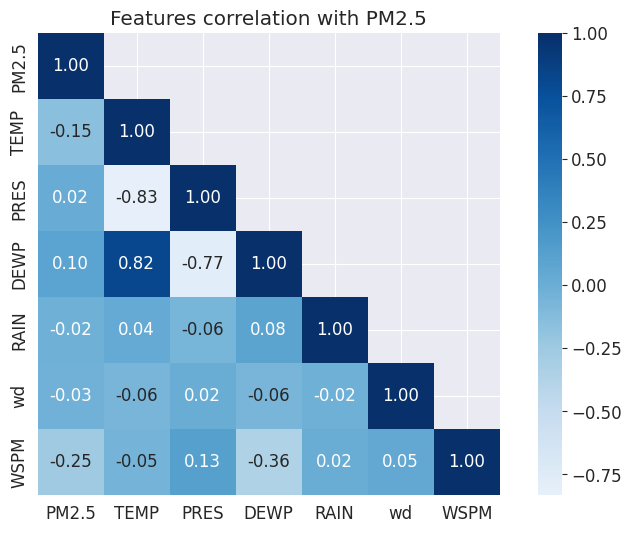

In [ ]:
# How features correlates with PM2.5
corr = pd.concat([y_pm25, features_X], axis='columns').corr()

plot_corr(corr, title='Features correlation with PM2.5')


**It can be observed that Wind Speed (WSPM) have strongest correlation, which is inverse, on PM2.5, followed by Temprature (TEMP). Increasing Wind Speed (WSPM) or Temprature (TEMP) correspond to a decreasing PM2.5 air quality index and vice versa. PM2.5 is also affected possitively correlated with Dew Point (DEWP), a lesser dew point also implies a slight decrease in the PM2.5 air quality index.**

<Axes: title={'center': 'PM2.5 Series [Gucheng]'}, xlabel='datetime'>

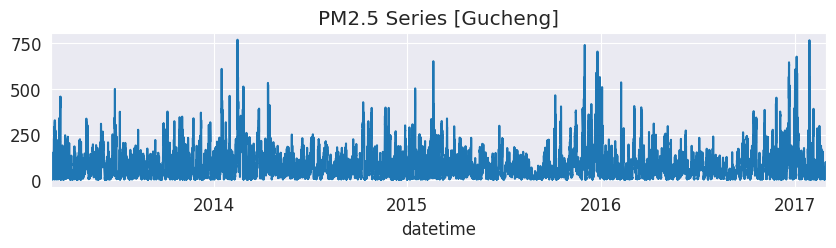

In [ ]:
plt.figure(figsize=(10,2))
y_pm25.plot(title='PM2.5 Series [Gucheng]')

<Axes: title={'center': 'PM2.5 Series (last 6 months) [Gucheng]'}, xlabel='datetime'>

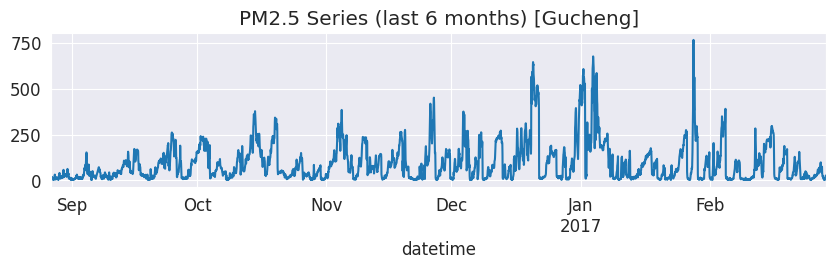

In [ ]:
# Last 6 months (To understand pattern)
plt.figure(figsize=(10,2))
y_pm25.iloc[-24*31*6:].plot(title='PM2.5 Series (last 6 months) [Gucheng]')

### Decomposing series

**As shown in the plot above, Series data has varying (increasing and decreasing) seasonality over time. So, we decompose using multiplicative decomposition model, to understand its seasonal and trend components**

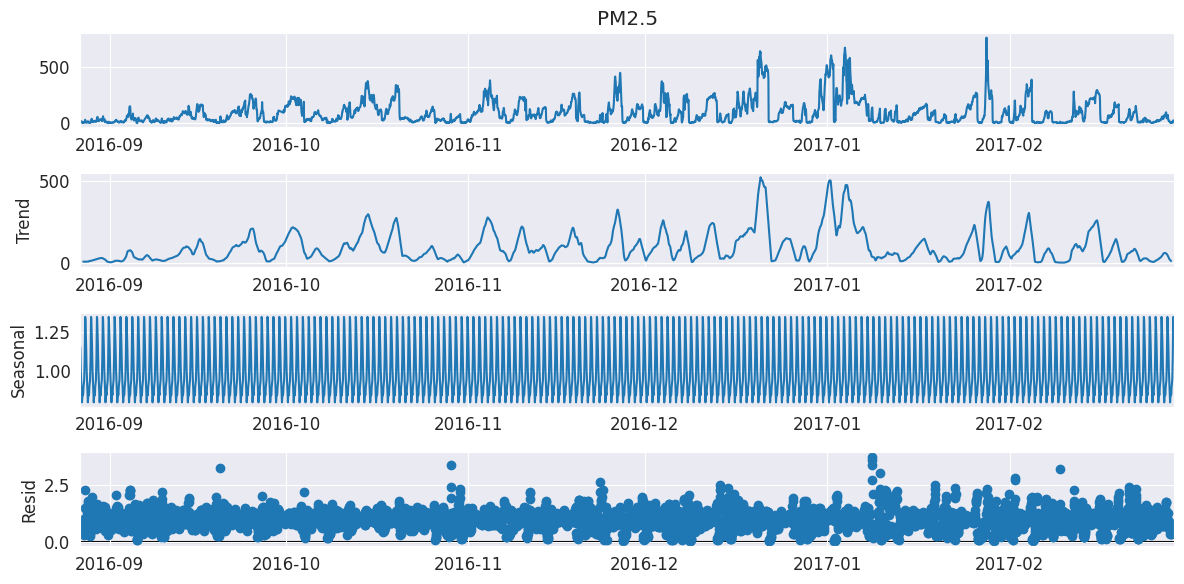

In [ ]:
# Decomposing Series into its trend and seasonal components
results = decompose_series_single(y_pm25[-24*31*6:], model='multiplicative') # last 6 months

<Figure size 2400x900 with 0 Axes>

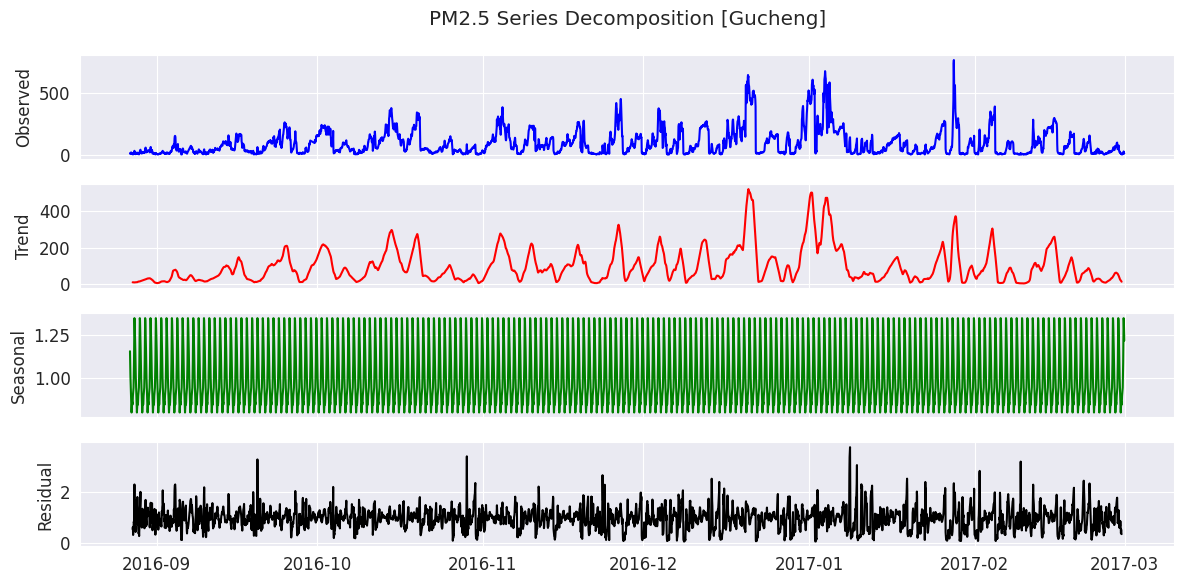

In [ ]:
plt.figure(figsize=(16, 6), dpi=150)
fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(results.observed, color='blue')
ax[0].set_title('PM2.5 Series Decomposition [Gucheng]\n')

ax[1].plot(results.trend, color='red')
ax[2].plot(results.seasonal, color='green')
ax[3].plot(results.resid, color='black')
ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

fig.tight_layout()
 

### Checking for PM2.5 series stationarity
using adfuller test

In [ ]:
test_for_stationarity_single(y_pm25)

p-value: 0.0
Series is stationary


In [ ]:
# logged_pm25 = pm25_data.apply(np.log)

# plt.figure(figsize=(12,2))
# logged_pm25[-24*31*6:].plot()

# pm25_data == logged_pm25.apply(np.exp) # reverse-log-transform

**Having confirmed that series is stationary, after testing using adfuller test for stationarity, we can then proceed to use the series for forecast without transformation**

## Training without Parameter Tunning (With No Exogenous Predictor Data)

### One Day Forecast (24 hours)

- 24 hours forecast (steps)
- 24 hours lag

In [ ]:
steps = 24 # 24 hours Forecast --- Next Day Forecast
lags = 24  # using past 24 hours window size 

#### Train-test splitting

In [ ]:
# last one month for testing (24 * 31 hours )
train_pm25, test_pm25 = split_train_test_series_single(series_data=y_pm25, test_size=steps)

print(f'Train set Dates:\t {train_pm25.index.min()}  --- {train_pm25.index.max()}')
print(f'Test set Dates:\t\t {test_pm25.index.min()}  --- {test_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-27 23:00:00
Test set Dates:		 2017-02-28 00:00:00  --- 2017-02-28 23:00:00


Text(0.5, 1.0, 'PM2.5 [Gucheng]\n')

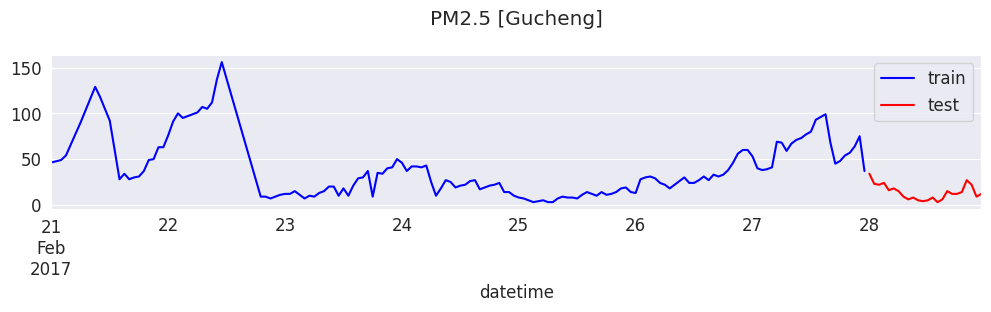

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*7:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 [Gucheng]\n')

#### Decision Tree

In [ ]:
# Training
dt_forecaster_pm25 = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(
        criterion='squared_error',
        min_samples_split=2,
        random_state=60
        ),
    lags = lags)

dt_forecaster_pm25.fit(y=train_pm25)
dt_forecaster_pm25

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-27 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 60, 'splitter': 'best'} 
Creation date: 2023-05-14 13:57:56 
Last fit date: 2023-05-14 13:57:58 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
preds_pm25_dt_nt = dt_forecaster_pm25.predict(steps=steps)
preds_pm25_dt_nt.index = test_pm25.index
# dt_preds_pm25 = test_pm25.apply(np.exp).round(0)
preds_pm25_dt_nt.head()

datetime
2017-02-28 00:00:00    29.0
2017-02-28 01:00:00    27.0
2017-02-28 02:00:00    16.0
2017-02-28 03:00:00    15.0
2017-02-28 04:00:00    18.0
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 1-Day Forecast of Decision Tree using 24-lags [Gucheng]\n')

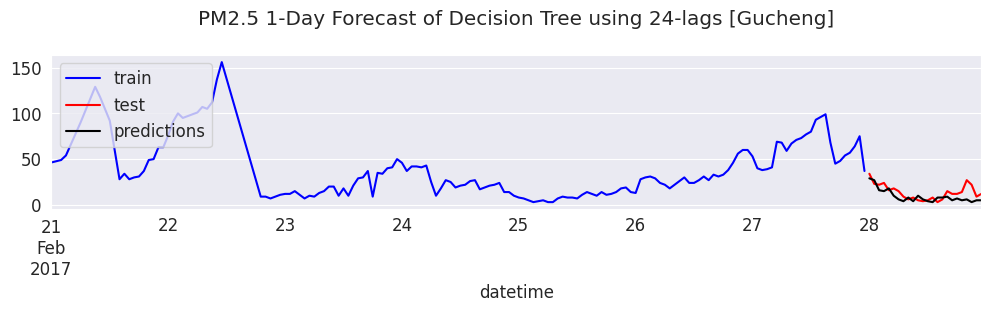

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*7:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
preds_pm25_dt_nt.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 1-Day Forecast of Decision Tree using 24-lags [Gucheng]\n')

In [ ]:
# Evaluations
results_pm25_dt_notune = evaluate_model_performance(
    y_true=test_pm25, 
    predictions=preds_pm25_dt_nt, 
    label='dt_pm25_no_tune')

results_pm25_dt_notune

,dt_pm25_no_tune
MAE,6.333
MSE,62.250
RMSE,7.890
R-Squared,0.032
MAPE,0.524


#### SVM (Regressor)

In [ ]:
# Training
svm_forecaster_pm25_nt = ForecasterAutoreg(
                regressor = LinearSVR(
                    epsilon=0.0, tol=0.0001, 
                    C=1.0, fit_intercept=True, 
                    random_state=60),
                lags = lags
             )

svm_forecaster_pm25_nt.fit(y=train_pm25)
svm_forecaster_pm25_nt

ForecasterAutoreg 
Regressor: LinearSVR(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-27 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': 60, 'tol': 0.0001, 'verbose': 0} 
Creation date: 2023-05-14 13:58:28 
Last fit date: 2023-05-14 13:58:37 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
svm_preds_pm25_nt = svm_forecaster_pm25_nt.predict(steps=steps)
svm_preds_pm25_nt.index = test_pm25.index
# svm_preds_pm25 = test_pm25.apply(np.exp).round(0)
svm_preds_pm25_nt.head()

datetime
2017-02-28 00:00:00    35.758244
2017-02-28 01:00:00    39.043288
2017-02-28 02:00:00    44.435466
2017-02-28 03:00:00    49.432570
2017-02-28 04:00:00    51.984925
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5  1-Day Forecast of SVM using 24-lags [Gucheng]\n')

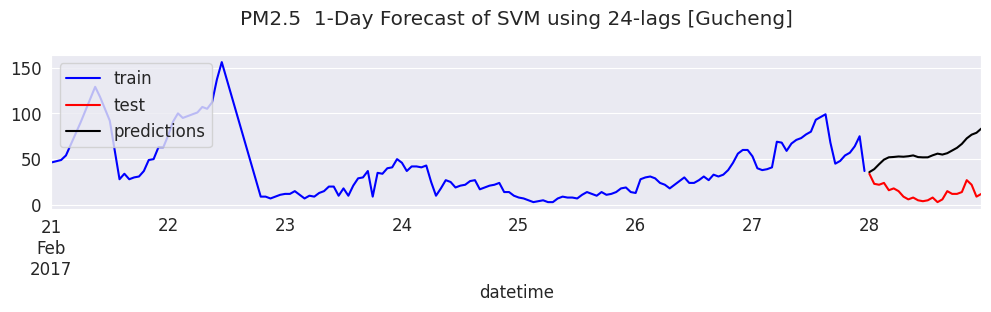

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*7:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
svm_preds_pm25_nt.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5  1-Day Forecast of SVM using 24-lags [Gucheng]\n')

In [ ]:
# Evaluations
results_pm25_svm_notune = evaluate_model_performance(
    y_true=test_pm25, predictions=svm_preds_pm25_nt, label='svm_pm25_no_tune')

results_pm25_svm_notune

,svm_pm25_no_tune
MAE,43.098
MSE,2081.494
RMSE,45.623
R-Squared,-31.377
MAPE,5.122


#### Random Forest (Regressor)

In [ ]:
# Training
rf_forecaster_pm25_nt = ForecasterAutoreg(
                regressor = RandomForestRegressor(
                    n_estimators=150, criterion='squared_error', 
                    bootstrap=True, random_state=60),
                lags = 24
             )

rf_forecaster_pm25_nt.fit(y=train_pm25)
rf_forecaster_pm25_nt

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=150, random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-27 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 60, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-14 13:58:53 
Last fit date: 2023-05-14 14:00:38 
Skforecast ve

In [ ]:
# Predictions
rf_preds_pm25_nt = rf_forecaster_pm25_nt.predict(steps=steps)
rf_preds_pm25_nt.index = test_pm25.index
# rf_preds_pm25 = test_pm25.apply(np.exp).round(0)
rf_preds_pm25_nt.head()

datetime
2017-02-28 00:00:00    38.080000
2017-02-28 01:00:00    37.442667
2017-02-28 02:00:00    38.555212
2017-02-28 03:00:00    41.510818
2017-02-28 04:00:00    44.321455
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 1-Day Forecast of Random Forest using 24-lags [Gucheng]\n')

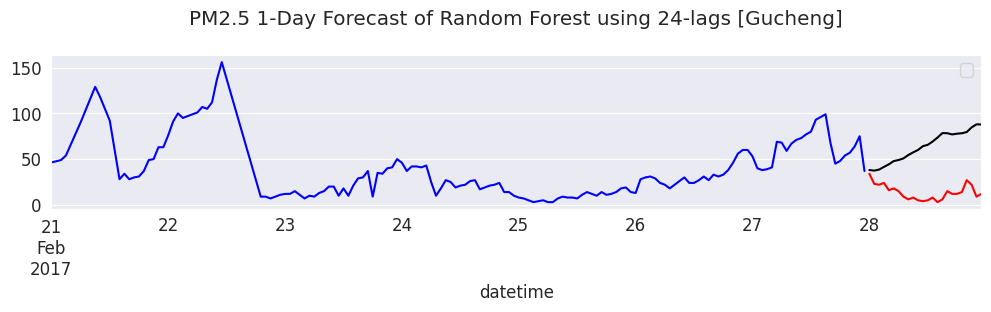

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*7:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
rf_preds_pm25_nt.plot(color='black', label='predictions')
plt.legend('')
plt.title('PM2.5 1-Day Forecast of Random Forest using 24-lags [Gucheng]\n')

In [ ]:
# Evaluations
results_pm25_rf_notune = evaluate_model_performance(
    y_true=test_pm25, predictions=rf_preds_pm25_nt, label='rf_pm25_no_tune')

results_pm25_rf_notune

,rf_pm25_no_tune
MAE,49.702
MSE,2910.703
RMSE,53.951
R-Squared,-44.275
MAPE,6.160


In [ ]:
results_one_day_forecast_nt = pd.concat([
    results_pm25_dt_notune, 
    results_pm25_rf_notune,
    results_pm25_svm_notune
    ], axis='columns')
results_one_day_forecast_nt

,dt_pm25_no_tune,rf_pm25_no_tune,svm_pm25_no_tune
MAE,6.333,49.702,43.098
MSE,62.250,2910.703,2081.494
RMSE,7.890,53.951,45.623
R-Squared,0.032,-44.275,-31.377
MAPE,0.524,6.160,5.122


<Figure size 800x400 with 0 Axes>

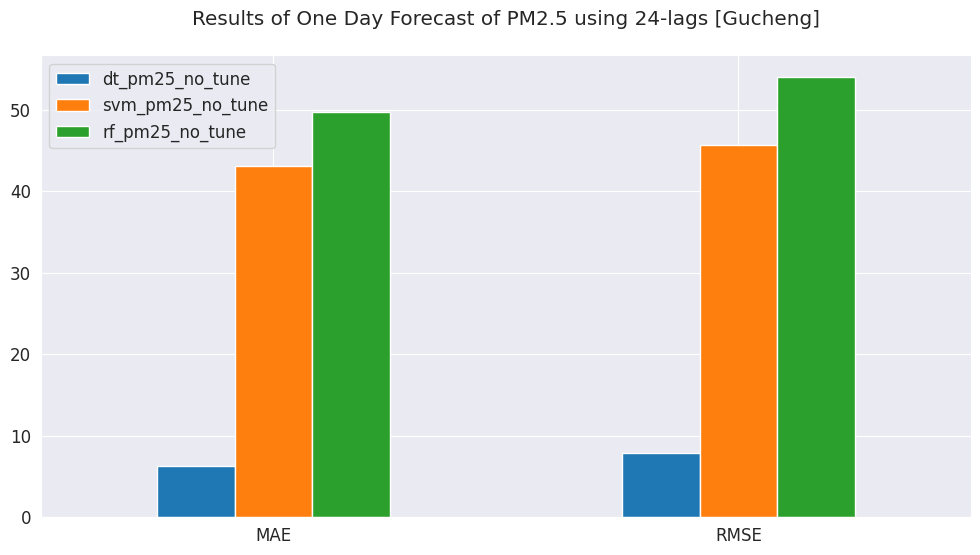

In [ ]:
plt.figure(figsize=(8,4))
results_one_day_forecast_nt.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of One Day Forecast of PM2.5 using 24-lags [Gucheng]\n', rot=0)
plt.legend(loc='upper left')

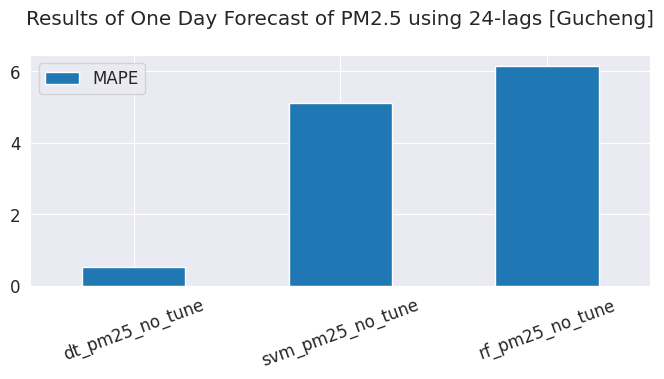

In [ ]:
results_one_day_forecast_nt.T['MAPE'].sort_values().T.plot.bar(
    title='Results of One Day Forecast of PM2.5 using 24-lags [Gucheng]\n', 
    figsize=(8,3), rot=20)
plt.legend(loc='upper left')

In [ ]:
# Saving a copy of results
results_one_day_forecast_nt.to_csv(f'{RESULTS_PATH}/results_1_day_forecast_notune_24lags_Gucheng.csv')

### Seven Days (168 hrs) Forecast without Exogeous Meterological Predictors

- Forecast next 168 hours (7 days) forecast (steps)
- Using 24 hours lag (Widow size), past data


In [ ]:
steps = 24 * 7 # 168 hours Forecast --- Next 7 Days Forecast
lags = 24  # using past 24 hours window size 

#### Train-test splitting

In [ ]:
# last one month for testing (24 * 31 hours )
train_pm25, test_pm25 = split_train_test_series_single(series_data=y_pm25, test_size=steps)

print(f'Train set Dates:\t {train_pm25.index.min()}  --- {train_pm25.index.max()}')
print(f'Test set Dates:\t\t {test_pm25.index.min()}  --- {test_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-21 23:00:00
Test set Dates:		 2017-02-22 00:00:00  --- 2017-02-28 23:00:00


Text(0.5, 1.0, 'PM2.5 Last 3-weeks [Gucheng]\n')

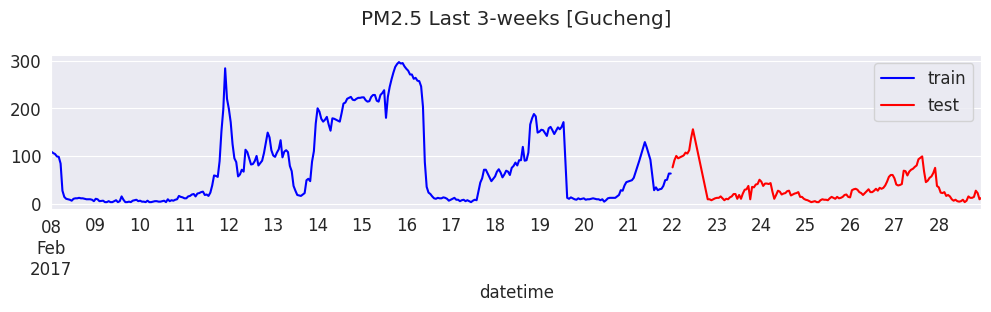

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*14:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 Last 3-weeks [Gucheng]\n')

#### Decision Tree

In [ ]:
# Training
dt_forecaster_pm25_nomet = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(
        criterion='squared_error',
        min_samples_split=2,
        random_state=60
        ),
    lags = lags)

dt_forecaster_pm25_nomet.fit(y=train_pm25)
dt_forecaster_pm25_nomet

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 60, 'splitter': 'best'} 
Creation date: 2023-05-14 14:05:46 
Last fit date: 2023-05-14 14:05:47 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
preds_pm25_dt_nt_nomet = dt_forecaster_pm25_nomet.predict(steps=steps)
# preds_pm25_dt_nt_nomet.index = test_pm25.index
# dt_preds_pm25 = test_pm25.apply(np.exp).round(0)
preds_pm25_dt_nt_nomet.head()

2017-02-22 00:00:00    67.0
2017-02-22 01:00:00    46.0
2017-02-22 02:00:00    51.0
2017-02-22 03:00:00    48.0
2017-02-22 04:00:00    49.0
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 7-Day Forecast of Decision Tree using 24-lags [Gucheng]\n')

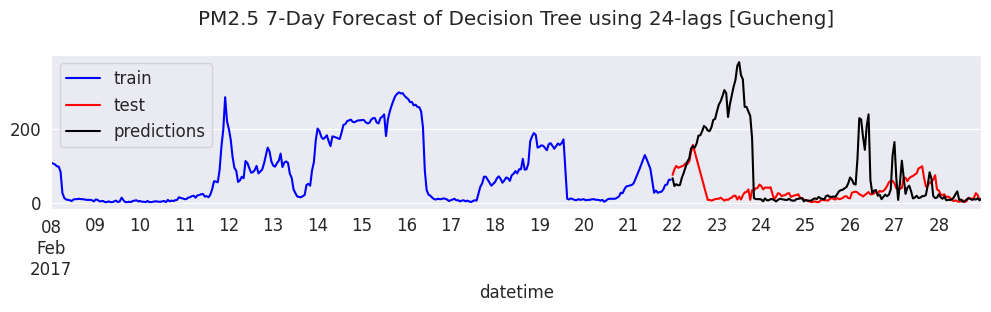

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*14:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
preds_pm25_dt_nt_nomet.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 7-Day Forecast of Decision Tree using 24-lags [Gucheng]\n')

In [ ]:
# Evaluations
results_pm25_dt_notune_nomet = evaluate_model_performance(
    y_true=test_pm25, 
    predictions=preds_pm25_dt_nt_nomet, 
    label='dt_pm25_no_tune_nomet')

results_pm25_dt_notune_nomet

,dt_pm25_no_tune_nomet
MAE,64.644
MSE,12434.287
RMSE,111.509
R-Squared,-11.538
MAPE,4.010


#### SVM (Regressor)

In [ ]:
# Training
svm_forecaster_pm25_nt_nomet = ForecasterAutoreg(
                regressor = LinearSVR(
                    epsilon=0.0, tol=0.0001, 
                    C=1.0, fit_intercept=True, 
                    random_state=60),
                lags = lags
             )

svm_forecaster_pm25_nt_nomet.fit(y=train_pm25)
svm_forecaster_pm25_nt_nomet

ForecasterAutoreg 
Regressor: LinearSVR(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': 60, 'tol': 0.0001, 'verbose': 0} 
Creation date: 2023-05-14 14:06:48 
Last fit date: 2023-05-14 14:06:57 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
svm_preds_pm25_nt_nomet = svm_forecaster_pm25_nt_nomet.predict(steps=steps)
svm_preds_pm25_nt_nomet.head()

2017-02-22 00:00:00     77.818595
2017-02-22 01:00:00     91.763717
2017-02-22 02:00:00    104.653121
2017-02-22 03:00:00    117.559724
2017-02-22 04:00:00    127.432472
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 7-Day Forecast of SVM using 24-lags [Gucheng]\n')

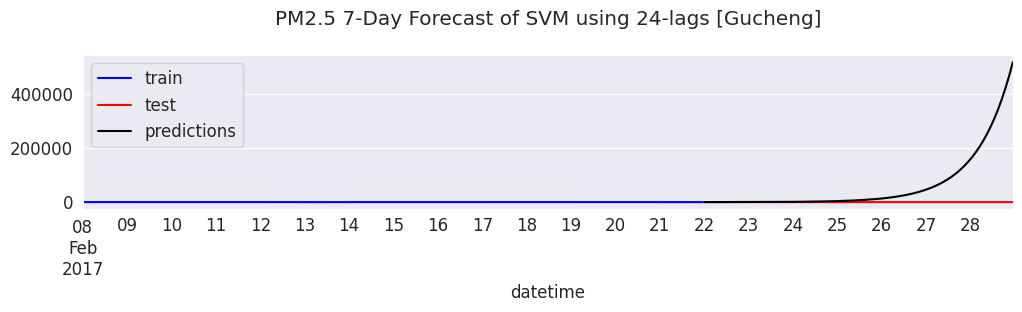

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*14:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
svm_preds_pm25_nt_nomet.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 7-Day Forecast of SVM using 24-lags [Gucheng]\n')

In [ ]:
# Evaluations
results_pm25_svm_notune_nomet = evaluate_model_performance(
    y_true=test_pm25, predictions=svm_preds_pm25_nt_nomet, label='svm_pm25_no_tune_nomet')

results_pm25_svm_notune_nomet

,svm_pm25_no_tune_nomet
MAE,6.111573e+04
MSE,1.618013e+10
RMSE,1.272012e+05
R-Squared,-1.631567e+07
MAPE,5.243535e+03


#### Random Forest (Regressor)

In [ ]:
# Training
rf_forecaster_pm25_nt_nomet = ForecasterAutoreg(
                regressor = RandomForestRegressor(
                    n_estimators=150, criterion='squared_error', 
                    bootstrap=True, random_state=60),
                lags = 24
             )

rf_forecaster_pm25_nt_nomet.fit(y=train_pm25)
rf_forecaster_pm25_nt_nomet

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=150, random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 60, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-14 14:07:07 
Last fit date: 2023-05-14 14:08:53 
Skforecast ve

In [ ]:
# Predictions
rf_preds_pm25_nt_nomet = rf_forecaster_pm25_nt_nomet.predict(steps=steps)
rf_preds_pm25_nt_nomet.head()

2017-02-22 00:00:00    65.598667
2017-02-22 01:00:00    74.960000
2017-02-22 02:00:00    75.495333
2017-02-22 03:00:00    76.166000
2017-02-22 04:00:00    80.217697
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 7-Day Forecast of Random Forest using 24-lags [Gucheng]\n')

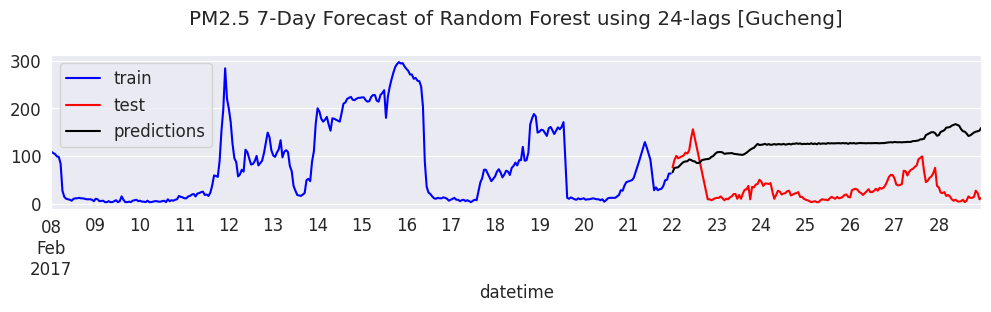

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*14:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
rf_preds_pm25_nt_nomet.plot(color='black', label='predictions')
plt.legend()
plt.title('PM2.5 7-Day Forecast of Random Forest using 24-lags [Gucheng]\n')

In [ ]:
# Evaluations
results_pm25_rf_notune_nomet = evaluate_model_performance(
    y_true=test_pm25, predictions=rf_preds_pm25_nt_nomet, label='rf_pm25_no_tune_nomet')

results_pm25_rf_notune_nomet

,rf_pm25_no_tune_nomet
MAE,93.221
MSE,9817.203
RMSE,99.082
R-Squared,-8.899
MAPE,7.270


In [ ]:
results_7_day_forecast_nt_nomet = pd.concat([
    results_pm25_dt_notune_nomet,
    results_pm25_rf_notune_nomet,
    results_pm25_svm_notune_nomet
    ], axis='columns')
results_7_day_forecast_nt_nomet

,dt_pm25_no_tune_nomet,rf_pm25_no_tune_nomet,svm_pm25_no_tune_nomet
MAE,64.644,93.221,6.111573e+04
MSE,12434.287,9817.203,1.618013e+10
RMSE,111.509,99.082,1.272012e+05
R-Squared,-11.538,-8.899,-1.631567e+07
MAPE,4.010,7.270,5.243535e+03


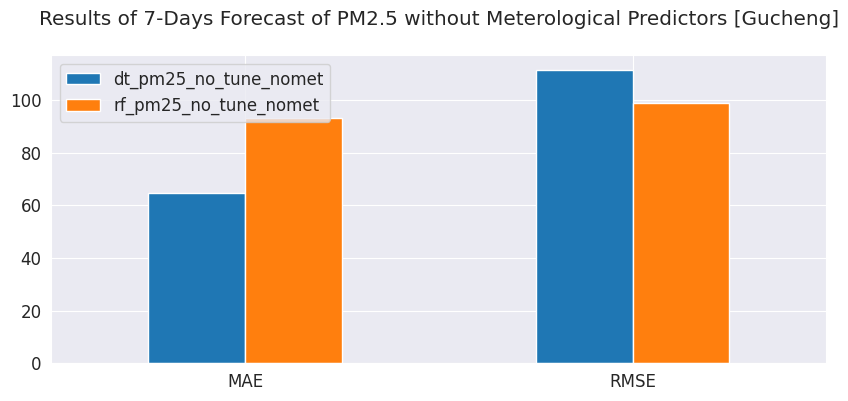

In [ ]:
results_7_day_forecast_nt_nomet.T[['MAE', 'RMSE']].sort_values(by='MAE').T.drop(columns=['svm_pm25_no_tune_nomet']).plot.bar(
    title='Results of 7-Days Forecast of PM2.5 without Meterological Predictors [Gucheng]\n',
    figsize=(10,4), rot=0)
plt.legend(loc='upper left')

In [ ]:
results_7_day_forecast_nt_nomet.T['MAPE'].sort_values()

dt_pm25_no_tune_nomet        4.010
rf_pm25_no_tune_nomet        7.270
svm_pm25_no_tune_nomet    5243.535
Name: MAPE, dtype: float64

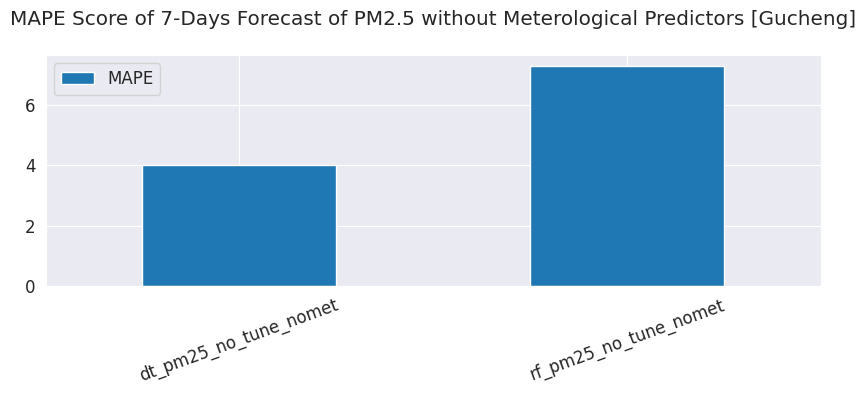

In [ ]:
results_7_day_forecast_nt_nomet.T['MAPE'].sort_values()[:2].T.plot.bar(
    title='MAPE Score of 7-Days Forecast of PM2.5 without Meterological Predictors [Gucheng]\n', 
    rot=20, figsize=(10,3))
plt.legend(loc='upper left')

In [ ]:
# Saving results
results_7_day_forecast_nt_nomet.to_csv(f'{RESULTS_PATH}/results_7_day_forecast_notune_nomet_24lags_Gucheng.csv')
results_one_day_forecast_nt.to_csv(f'{RESULTS_PATH}/results_1_day_forecast_notune_nomet_24lags_Gucheng.csv')

### One Month (next 744 hrs) Forecast Without exogenous data

Using 

- 48 hours lag
- Log transformation on PM2.5 (to make series more stationary)
- Custom built

In [12]:
STEPS = 24 * 31 # forecast next one month PM2.5 = next 744 hrs
N_LAGS = 48 # window size of recent 48 hours data

#### Preparing data

In [13]:
# Converting Series data into supervised learning data format

pm25_data = series_to_supervised_dataset_single(
    y_pm25.apply(np.log), n_lags=N_LAGS)
pm25_data.head(3)

,PM25t-48,PM25t-47,PM25t-46,PM25t-45,PM25t-44,PM25t-43,PM25t-42,PM25t-41,PM25t-40,PM25t-39,...,PM25t-9,PM25t-8,PM25t-7,PM25t-6,PM25t-5,PM25t-4,PM25t-3,PM25t-2,PM25t-1,PM2.5
datetime,,,,,,,,,,,,,,,,,,,,,
2013-03-03 00:00:00,1.791759,1.791759,1.609438,1.791759,1.609438,1.386294,1.098612,1.609438,1.609438,1.386294,...,3.583519,3.850148,4.077537,4.143135,4.248495,4.454347,4.584967,4.584967,4.454347,4.394449
2013-03-03 01:00:00,1.791759,1.609438,1.791759,1.609438,1.386294,1.098612,1.609438,1.609438,1.386294,1.945910,...,3.850148,4.077537,4.143135,4.248495,4.454347,4.584967,4.584967,4.454347,4.394449,4.382027
2013-03-03 02:00:00,1.609438,1.791759,1.609438,1.386294,1.098612,1.609438,1.609438,1.386294,1.945910,1.098612,...,4.077537,4.143135,4.248495,4.454347,4.584967,4.584967,4.454347,4.394449,4.382027,4.430817


In [14]:
# Train-Test split

Xtrain, ytrain, Xtest, ytest = split_train_test_series_multivariate_series(pm25_data, test_size=STEPS)

In [15]:
Xtrain.head(3)

,PM25t-48,PM25t-47,PM25t-46,PM25t-45,PM25t-44,PM25t-43,PM25t-42,PM25t-41,PM25t-40,PM25t-39,...,PM25t-10,PM25t-9,PM25t-8,PM25t-7,PM25t-6,PM25t-5,PM25t-4,PM25t-3,PM25t-2,PM25t-1
datetime,,,,,,,,,,,,,,,,,,,,,
2013-03-03 00:00:00,1.791759,1.791759,1.609438,1.791759,1.609438,1.386294,1.098612,1.609438,1.609438,1.386294,...,3.465736,3.583519,3.850148,4.077537,4.143135,4.248495,4.454347,4.584967,4.584967,4.454347
2013-03-03 01:00:00,1.791759,1.609438,1.791759,1.609438,1.386294,1.098612,1.609438,1.609438,1.386294,1.945910,...,3.583519,3.850148,4.077537,4.143135,4.248495,4.454347,4.584967,4.584967,4.454347,4.394449
2013-03-03 02:00:00,1.609438,1.791759,1.609438,1.386294,1.098612,1.609438,1.609438,1.386294,1.945910,1.098612,...,3.850148,4.077537,4.143135,4.248495,4.454347,4.584967,4.584967,4.454347,4.394449,4.382027


In [16]:
ytrain.head(3)

datetime
2013-03-03 00:00:00    4.394449
2013-03-03 01:00:00    4.382027
2013-03-03 02:00:00    4.430817
Freq: H, Name: PM2.5, dtype: float64

In [17]:
Xtest.head(3)

,PM25t-48,PM25t-47,PM25t-46,PM25t-45,PM25t-44,PM25t-43,PM25t-42,PM25t-41,PM25t-40,PM25t-39,...,PM25t-10,PM25t-9,PM25t-8,PM25t-7,PM25t-6,PM25t-5,PM25t-4,PM25t-3,PM25t-2,PM25t-1
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-29 00:00:00,1.791759,2.079442,1.609438,1.945910,1.791759,1.386294,1.098612,2.197225,2.564949,3.218876,...,5.407172,5.375278,5.424950,5.407172,5.455321,5.505332,5.556828,5.690359,5.568345,5.556828
2017-01-29 01:00:00,2.079442,1.609438,1.945910,1.791759,1.386294,1.098612,2.197225,2.564949,3.218876,3.610918,...,5.375278,5.424950,5.407172,5.455321,5.505332,5.556828,5.690359,5.568345,5.556828,5.459586
2017-01-29 02:00:00,1.609438,1.945910,1.791759,1.386294,1.098612,2.197225,2.564949,3.218876,3.610918,3.737670,...,5.424950,5.407172,5.455321,5.505332,5.556828,5.690359,5.568345,5.556828,5.459586,5.472271


In [ ]:
ytest.head(3)

datetime
2017-01-29 00:00:00    5.459586
2017-01-29 01:00:00    5.472271
2017-01-29 02:00:00    5.298317
Freq: H, Name: PM2.5, dtype: float64

#### Decision Tree Regressor

In [18]:
# Decision Tree Regressor
dt = DecisionTreeRegressor(criterion='squared_error', random_state=60)

dt.fit(Xtrain.values, ytrain.values)
preds = predict_series_multivariate(Xtest, model=dt, n_lags=N_LAGS)
preds.apply(np.exp).head()

(1, 48)


datetime
2017-01-29 00:00:00    253.0
2017-01-29 01:00:00    253.0
2017-01-29 02:00:00    288.0
2017-01-29 03:00:00    121.0
2017-01-29 04:00:00     64.0
Freq: H, Name: PM2.5, dtype: float64

In [19]:
results_dt_pm25_nt = evaluate_model_performance(
    ytest.apply(np.exp), preds.apply(np.exp), label='dt_pm25_nt')

results_dt_pm25_nt

,dt_pm25_nt
MAE,75.376
MSE,9958.434
RMSE,99.792
R-Squared,-0.519
MAPE,3.930


Text(0.5, 1.0, 'PM2.5 1-Month Forecast of Decision Tree using 48-lags [custom][Gucheng]\n')

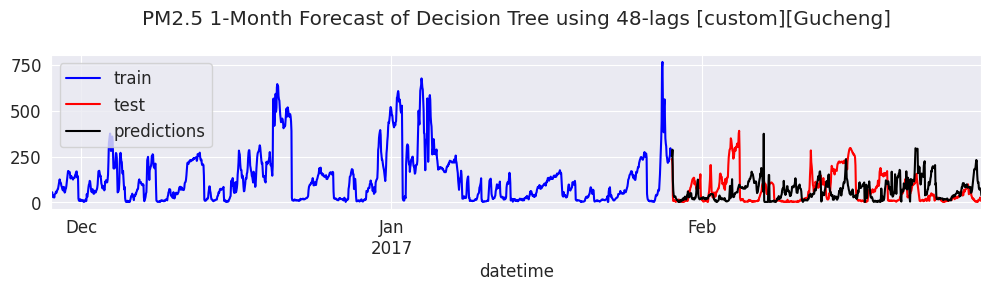

In [20]:
plt.figure(figsize=(12,2))
ytrain[-24*31*2:].apply(np.exp).plot(color='blue', label='train')
ytest.apply(np.exp).plot(color='red', label='test')
preds.apply(np.exp).plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 1-Month Forecast of Decision Tree using 48-lags [custom][Gucheng]\n')

#### Random Forest

In [21]:
# Random Forest
rf = RandomForestRegressor(random_state=60)
rf.fit(Xtrain.values, ytrain.values)

preds_rf = predict_series_multivariate(Xtest, model=rf, n_lags=N_LAGS)
preds_rf.apply(np.exp).head()

(1, 48)


datetime
2017-01-29 00:00:00    256.798956
2017-01-29 01:00:00    250.018962
2017-01-29 02:00:00    239.276349
2017-01-29 03:00:00    212.781663
2017-01-29 04:00:00    164.107622
Freq: H, Name: PM2.5, dtype: float64

In [22]:
results_rf_pm25_nt = evaluate_model_performance(
    ytest.apply(np.exp), preds_rf.apply(np.exp), label='rf_pm25_nt')

results_rf_pm25_nt

,rf_pm25_nt
MAE,62.391
MSE,6529.298
RMSE,80.804
R-Squared,0.004
MAPE,3.638


Text(0.5, 1.0, 'PM2.5 1-Month Forecast of Random Forest using 48-lags [custom][Gucheng]\n')

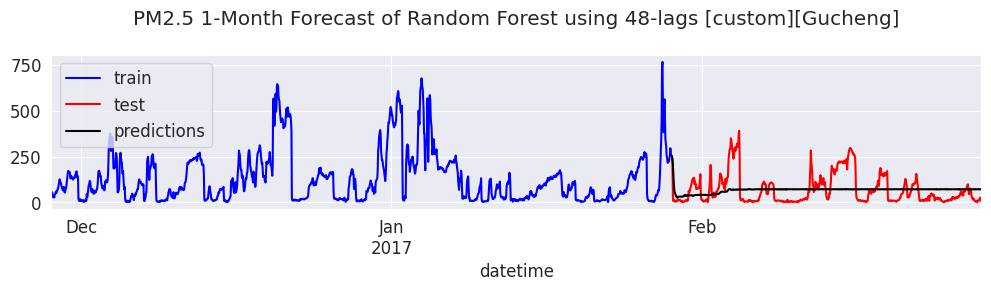

In [23]:
plt.figure(figsize=(12,2))
ytrain[-24*31*2:].apply(np.exp).plot(color='blue', label='train')
ytest.apply(np.exp).plot(color='red', label='test')
preds_rf.apply(np.exp).plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 1-Month Forecast of Random Forest using 48-lags [custom][Gucheng]\n')

#### Support Vector Machine (SVM)

In [24]:
# SVR
svr = LinearSVR(random_state=60)
svr.fit(Xtrain.values, ytrain.values)

preds_svr = predict_series_multivariate(Xtest, model=svr, n_lags=N_LAGS)
preds_svr.apply(np.exp).head()

(1, 48)


datetime
2017-01-29 00:00:00    229.864737
2017-01-29 01:00:00    195.919465
2017-01-29 02:00:00    164.242212
2017-01-29 03:00:00    133.520157
2017-01-29 04:00:00    108.092890
Freq: H, Name: PM2.5, dtype: float64

In [25]:
results_svr_pm25_nt = evaluate_model_performance(
    ytest.apply(np.exp), preds_svr.apply(np.exp), label='svr_pm25_nt')

results_svr_pm25_nt

,svr_pm25_nt
MAE,61.078
MSE,9125.982
RMSE,95.530
R-Squared,-0.392
MAPE,1.521


Text(0.5, 1.0, 'PM2.5 1-Month Forecast of SVM using 48-lags [custom][Gucheng]\n')

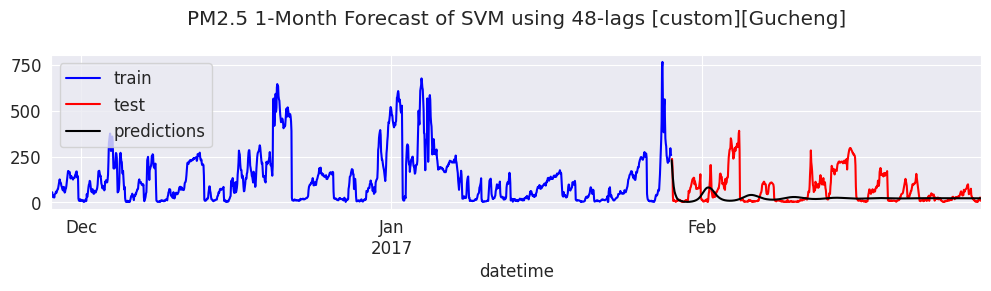

In [26]:
plt.figure(figsize=(12,2))
ytrain[-24*31*2:].apply(np.exp).plot(color='blue', label='train')
ytest.apply(np.exp).plot(color='red', label='test')
preds_svr.apply(np.exp).plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 1-Month Forecast of SVM using 48-lags [custom][Gucheng]\n')

In [27]:
results_pm25_1_month_forecast_notune_nomet_48lags = pd.concat([
    results_dt_pm25_nt, results_svr_pm25_nt, results_rf_pm25_nt],
    axis='columns')

results_pm25_1_month_forecast_notune_nomet_48lags 

,dt_pm25_nt,svr_pm25_nt,rf_pm25_nt
MAE,75.376,61.078,62.391
MSE,9958.434,9125.982,6529.298
RMSE,99.792,95.530,80.804
R-Squared,-0.519,-0.392,0.004
MAPE,3.930,1.521,3.638


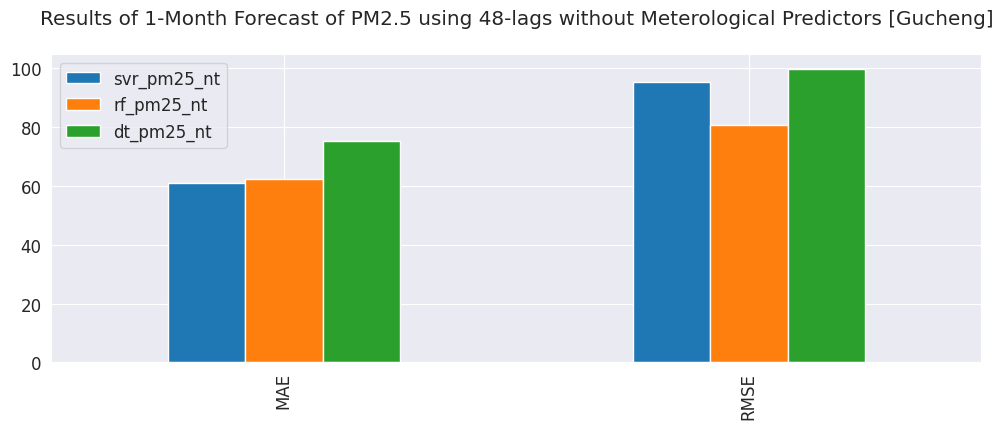

In [28]:
results_pm25_1_month_forecast_notune_nomet_48lags.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of 1-Month Forecast of PM2.5 using 48-lags without Meterological Predictors [Gucheng]\n',
    figsize=(12,4))
plt.legend(loc='upper left')

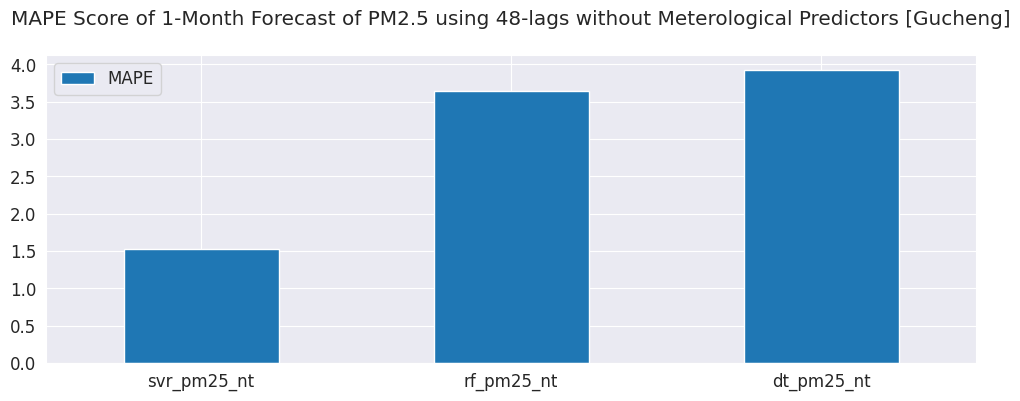

In [29]:
results_pm25_1_month_forecast_notune_nomet_48lags.T['MAPE'].sort_values().T.plot.bar(
    title='MAPE Score of 1-Month Forecast of PM2.5 using 48-lags without Meterological Predictors [Gucheng]\n',
    figsize=(12,4), rot=0)
plt.legend(loc='upper left')

In [30]:
# Saving a copy of the results
results_pm25_1_month_forecast_notune_nomet_48lags.to_csv(f'{RESULTS_PATH}/results_pm25_1_month_forecast_notune_nomet_48lags.csv')


## MODDELING FORECAST WITH EXOGENOUS METEROLOGICAL VARIABLES

### Seven Days  (168 hours, 1 week) Forecast (trained with Exogenous Meterological Predictor Variables included) + Feature Selection 

- Trained with exogenous meterology data
- 24 hours lag (use past 24 hrs data)
- One week (168 hrs) forecast
- Feature Selection based on pearson correlation with Target (PM2.5) variable

In [31]:
steps = 24 * 7 # 168 hours Forecast --- One Week Forecast
lags = 24  # using past 24 hours window size

#### Preparing data and Feature Selection

In [ ]:
features_X.corrwith(y_pm25).sort_values()

WSPM   -0.251702
TEMP   -0.145860
wd     -0.025076
RAIN   -0.020184
PRES    0.022596
DEWP    0.097060
dtype: float64

<Axes: title={'center': 'Feature Correlation with PM2.5 [Gucheng]\n'}>

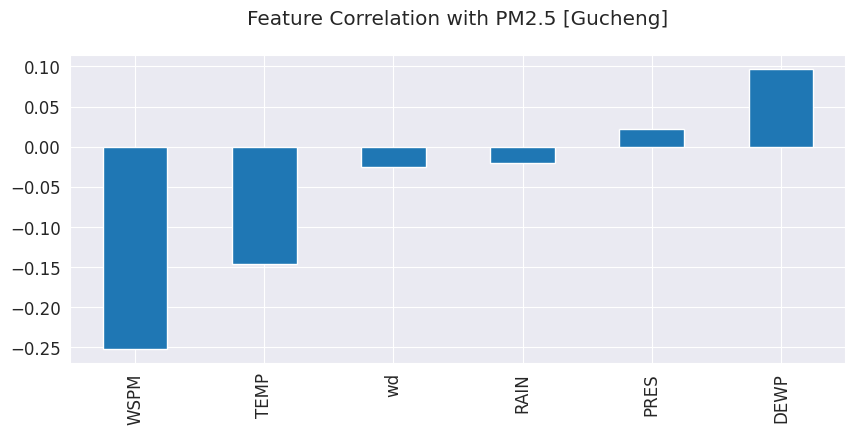

In [ ]:
## Feature Selection by correlation
features_X.corrwith(y_pm25).sort_values().plot.bar(title='Feature Correlation with PM2.5 [Gucheng]\n', figsize=(10,4))

**Selected Features are {'WSPM', 'wd', 'TEMP'}**

In [32]:
pm25_exog_data = pd.concat([features_X[['WSPM', 'wd', 'TEMP']], y_pm25], axis='columns')
pm25_exog_data.head()

,WSPM,wd,TEMP,PM2.5
datetime,,,,
2013-03-01 00:00:00,4.4,315.0,0.1,6.0
2013-03-01 01:00:00,4.0,315.0,-0.3,6.0
2013-03-01 02:00:00,4.6,292.5,-0.7,5.0
2013-03-01 03:00:00,2.8,270.0,-1.0,6.0
2013-03-01 04:00:00,3.6,292.5,-1.3,5.0


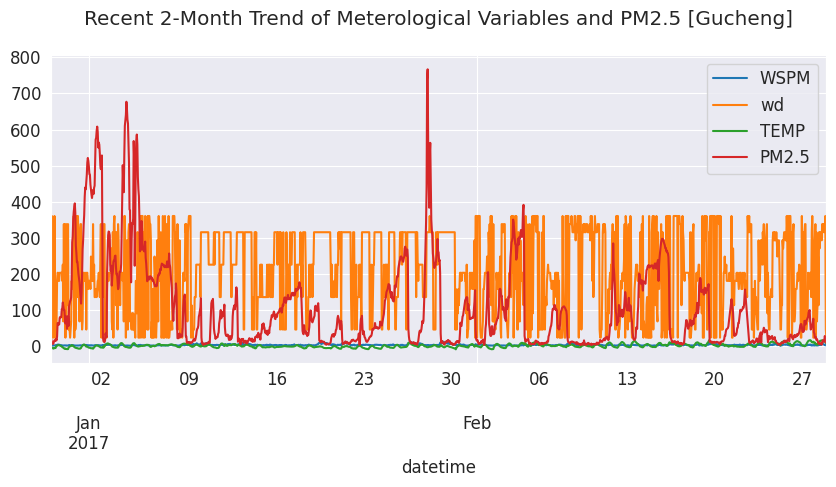

In [ ]:
plt.figure(figsize=(10,4))
for col in pm25_exog_data.columns:
    pm25_exog_data.iloc[-24*31*2:][col].plot(label=col)

plt.title('Recent 2-Month Trend of Meterological Variables and PM2.5 [Gucheng]\n')
plt.legend()

#### Data Segmentation

In [33]:
# last one month for testing (24 * 31 hours )
Xtrain_exo_pm25, ytrain_exo_pm25, Xtest_exo_pm25, ytest_exo_pm25 = split_train_test_series_multivariate_series(
    df=pm25_exog_data, test_size=steps)

print(f'Train set Dates:\t {ytrain_exo_pm25.index.min()}  --- {ytrain_exo_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_exo_pm25.index.min()}  --- {ytest_exo_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-21 23:00:00
Test set Dates:		 2017-02-22 00:00:00  --- 2017-02-28 23:00:00


In [ ]:
Xtrain_exo_pm25.head(3)

,WSPM,wd,TEMP
datetime,,,
2013-03-01 00:00:00,4.4,315.0,0.1
2013-03-01 01:00:00,4.0,315.0,-0.3
2013-03-01 02:00:00,4.6,292.5,-0.7


In [ ]:
ytrain_exo_pm25.head(3)

datetime
2013-03-01 00:00:00    6.0
2013-03-01 01:00:00    6.0
2013-03-01 02:00:00    5.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
Xtest_exo_pm25.head(3)

,WSPM,wd,TEMP
datetime,,,
2017-02-22 00:00:00,2.3,180.0,-2.9
2017-02-22 01:00:00,3.2,202.5,-3.0
2017-02-22 02:00:00,2.2,202.5,-2.9


In [ ]:
ytest_exo_pm25.head(3)

datetime
2017-02-22 00:00:00     76.0
2017-02-22 01:00:00     91.0
2017-02-22 02:00:00    100.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Xtrain shape: {Xtrain_exo_pm25.shape}')
print(f'Xtest shape: {Xtest_exo_pm25.shape}')

Xtrain shape: (34896, 3)
Xtest shape: (168, 3)


Text(0.5, 1.0, 'PM2.5 Recent 3-weeks [Gucheng]\n')

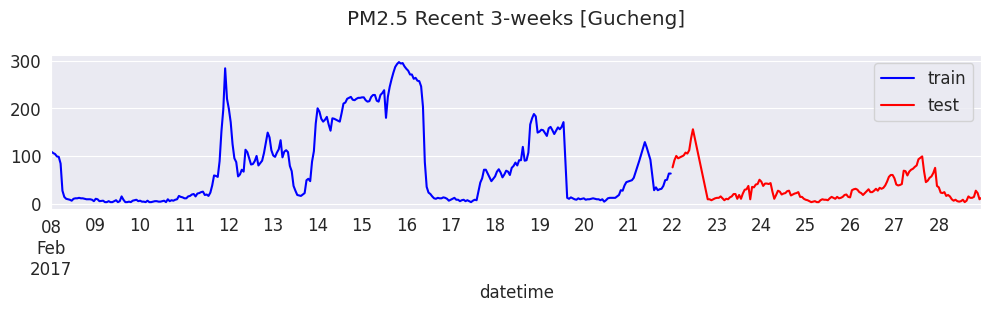

In [ ]:
plt.figure(figsize=(12,2))
ytrain_exo_pm25[-24*14:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 Recent 3-weeks [Gucheng]\n')

#### Decision Tree

In [42]:
# Training
dt_forecaster_pm25_exo_sel = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(
        criterion='squared_error',
        min_samples_split=2,
        random_state=60
        ),
    lags = lags)

dt_forecaster_pm25_exo_sel.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
dt_forecaster_pm25_exo_sel

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['WSPM', 'wd', 'TEMP'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 60, 'splitter': 'best'} 
Creation date: 2023-05-15 22:57:36 
Last fit date: 2023-05-15 22:57:38 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [43]:
# Predictions
preds_pm25_dt_nt_exo_sel = dt_forecaster_pm25_exo_sel.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_dt_nt_exo_sel.head()

2017-02-22 00:00:00    52.0
2017-02-22 01:00:00    43.0
2017-02-22 02:00:00    59.0
2017-02-22 03:00:00    47.0
2017-02-22 04:00:00    52.0
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Day Forecast of Decision Tree using 24-lags [Gucheng]\n')

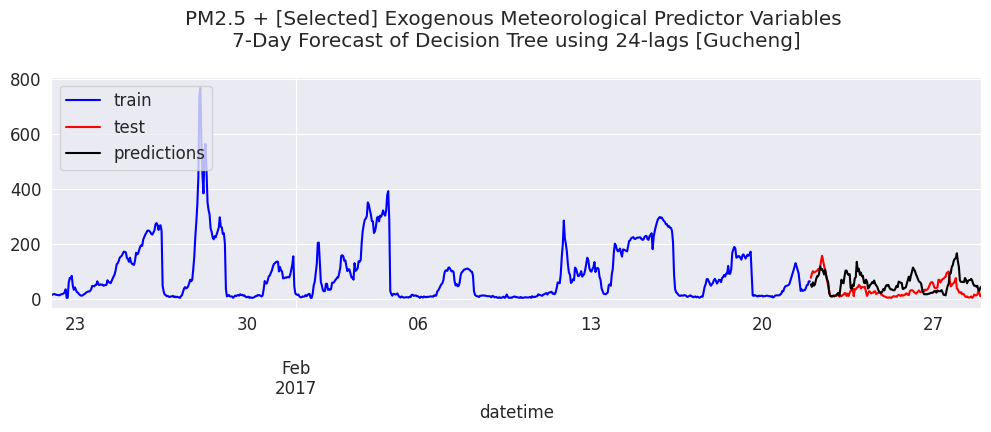

In [44]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*31:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_dt_nt_exo_sel.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Day Forecast of Decision Tree using 24-lags [Gucheng]\n')

In [45]:
# Evaluations
results_pm25_dt_notune_exo_sel = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_dt_nt_exo_sel, 
    label='dt_pm25_no_tune_exo_sel')

results_pm25_dt_notune_exo_sel

,dt_pm25_no_tune_exo_sel
MAE,37.546
MSE,1976.488
RMSE,44.458
R-Squared,-0.993
MAPE,2.450


#### SVM (Regressor)

In [48]:
# Training
svm_forecaster_pm25_nt_exo_sel = ForecasterAutoreg(
                regressor = LinearSVR(
                    epsilon=0.0, tol=0.0001, 
                    C=1.0, fit_intercept=True, 
                    random_state=60),
                lags = lags
             )

svm_forecaster_pm25_nt_exo_sel.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
svm_forecaster_pm25_nt_exo_sel

ForecasterAutoreg 
Regressor: LinearSVR(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['WSPM', 'wd', 'TEMP'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': 60, 'tol': 0.0001, 'verbose': 0} 
Creation date: 2023-05-15 22:59:00 
Last fit date: 2023-05-15 22:59:13 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [49]:
# Predictions
preds_pm25_svm_nt_exo_sel = svm_forecaster_pm25_nt_exo_sel.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_svm_nt_exo_sel.head()

2017-02-22 00:00:00     77.661471
2017-02-22 01:00:00     92.323660
2017-02-22 02:00:00    104.753954
2017-02-22 03:00:00    117.229040
2017-02-22 04:00:00    127.610817
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Days Forecast of SVM using 24-lags [Gucheng]\n')

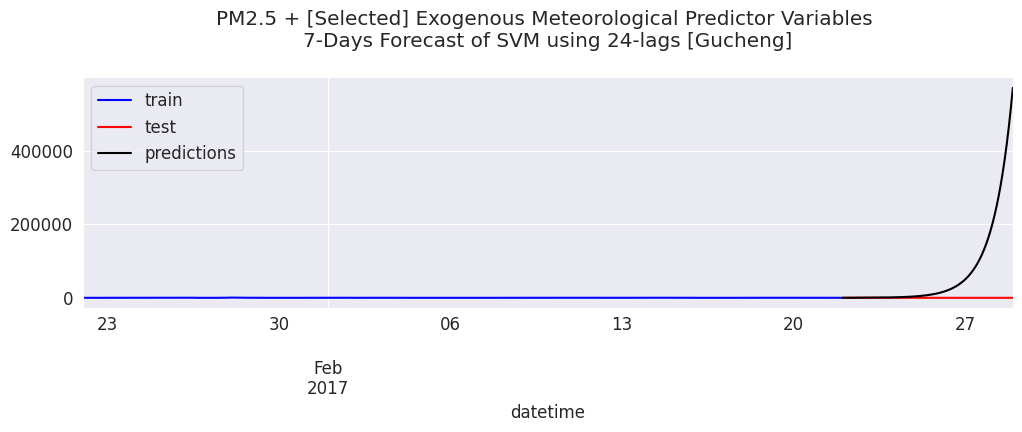

In [50]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*31:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_svm_nt_exo_sel.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Days Forecast of SVM using 24-lags [Gucheng]\n')

In [51]:
# Evaluations
results_pm25_svm_notune_exo_sel = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_svm_nt_exo_sel, 
    label='svm_pm25_no_tune_exo_sel')

results_pm25_svm_notune_exo_sel

,svm_pm25_no_tune_exo_sel
MAE,6.681859e+04
MSE,1.957401e+10
RMSE,1.399071e+05
R-Squared,-1.973798e+07
MAPE,5.751231e+03


#### Radom Forest (Regressor)


In [37]:
# Training
rf_forecaster_pm25_nt_exo_sel = ForecasterAutoreg(
                regressor =RandomForestRegressor(
                    n_estimators=150, criterion='squared_error', 
                    bootstrap=True, random_state=60),
                lags = lags
             )

rf_forecaster_pm25_nt_exo_sel.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
rf_forecaster_pm25_nt_exo_sel

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=150, random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['WSPM', 'wd', 'TEMP'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 60, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-15 22:54:08 

In [38]:
# Predictions
preds_pm25_rf_nt_exo_sel = rf_forecaster_pm25_nt_exo_sel.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_rf_nt_exo_sel.head()

2017-02-22 00:00:00    65.506667
2017-02-22 01:00:00    69.140000
2017-02-22 02:00:00    74.806667
2017-02-22 03:00:00    80.922667
2017-02-22 04:00:00    83.480000
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Days Forecast of Random Forest using 24-lags [Gucheng]\n')

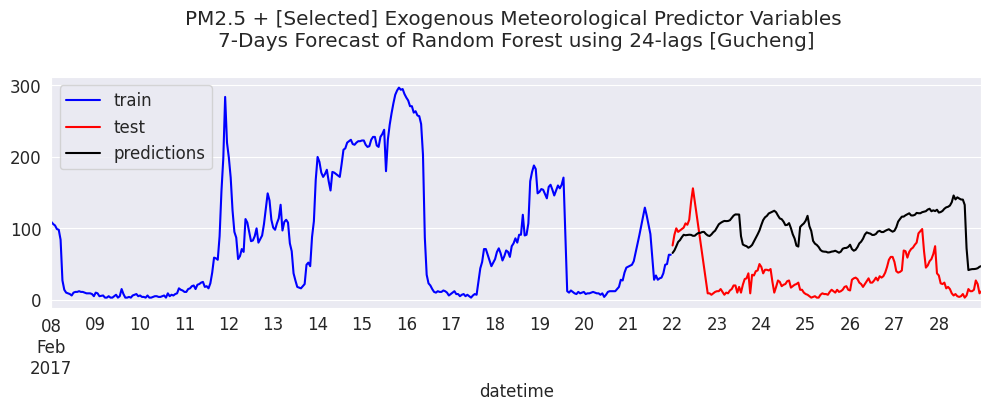

In [39]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*14:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_rf_nt_exo_sel.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Days Forecast of Random Forest using 24-lags [Gucheng]\n')

In [40]:
# Evaluations
results_pm25_rf_notune_exo_sel = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_rf_nt_exo_sel, 
    label='rf_pm25_no_tune_exo_sel')

results_pm25_rf_notune_exo_sel

,rf_pm25_no_tune_exo_sel
MAE,66.373
MSE,5290.850
RMSE,72.738
R-Squared,-4.335
MAPE,5.223


#### Combined Results

In [52]:
results_7_day_forecast_nt_exo_sel = pd.concat([
    results_pm25_dt_notune_exo_sel, 
    results_pm25_rf_notune_exo_sel,
    results_pm25_svm_notune_exo_sel
    ], axis='columns')

results_7_day_forecast_nt_exo_sel

,dt_pm25_no_tune_exo_sel,rf_pm25_no_tune_exo_sel,svm_pm25_no_tune_exo_sel
MAE,37.546,66.373,6.681859e+04
MSE,1976.488,5290.850,1.957401e+10
RMSE,44.458,72.738,1.399071e+05
R-Squared,-0.993,-4.335,-1.973798e+07
MAPE,2.450,5.223,5.751231e+03


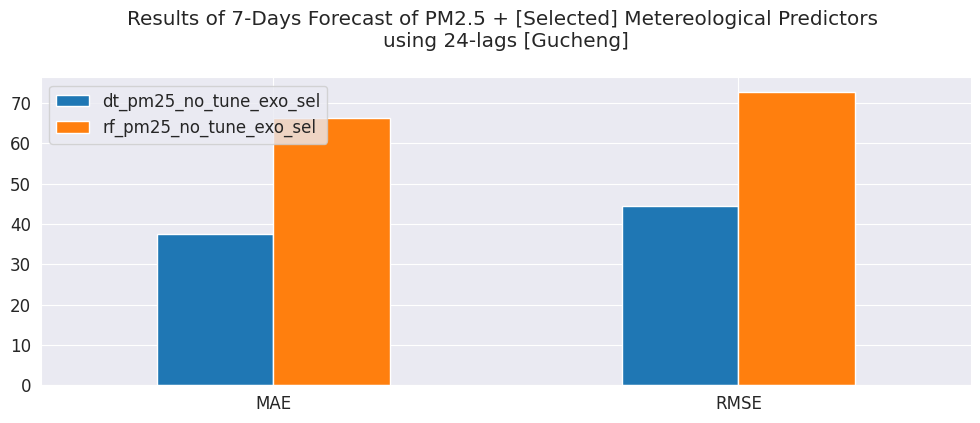

In [53]:
results_7_day_forecast_nt_exo_sel.T[['MAE', 'RMSE']].sort_values(by='MAE').T.drop(columns=['svm_pm25_no_tune_exo_sel']).plot.bar(
    title='Results of 7-Days Forecast of PM2.5 + [Selected] Metereological Predictors \nusing 24-lags [Gucheng]\n',
    rot=0, figsize=(12,4))
plt.legend(loc='upper left')

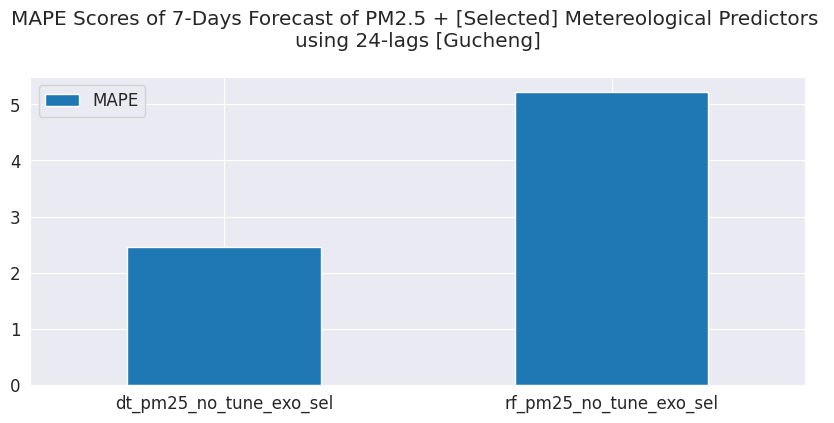

In [54]:
results_7_day_forecast_nt_exo_sel.T['MAPE'].sort_values().T[:2].plot.bar(
    title='MAPE Scores of 7-Days Forecast of PM2.5 + [Selected] Metereological Predictors \nusing 24-lags [Gucheng]\n',
    rot=0, figsize=(10,4))
plt.legend(loc='upper left')

In [55]:
# Saving a copy of results
results_7_day_forecast_nt_exo_sel.to_csv(f'{RESULTS_PATH}/results_7_day_forecast_notune_exo_sel_24lags_with_FeatureSelection.csv')

### Seven Days (1 week = 168 hours) Forecast (trained with Exogenous Meterological Predictor Variables included) + All-Features

- Trained with exogenous meterology data
- 24 hours lag (use past 24 hrs data)
- One week (168 hrs) forecast
- No Feature Selection (all features are used for comparative analysis)

In [56]:
steps = 24 * 7 # 168 hours Forecast --- One Week Forecast
lags = 24  # using past 24 hours window size

#### Data Preparation

In [57]:
pm25_exog_data = pd.concat([features_X, y_pm25], axis='columns')
pm25_exog_data.head()

,TEMP,PRES,DEWP,RAIN,wd,WSPM,PM2.5
datetime,,,,,,,
2013-03-01 00:00:00,0.1,1021.1,-18.6,0.0,315.0,4.4,6.0
2013-03-01 01:00:00,-0.3,1021.5,-19.0,0.0,315.0,4.0,6.0
2013-03-01 02:00:00,-0.7,1021.5,-19.8,0.0,292.5,4.6,5.0
2013-03-01 03:00:00,-1.0,1022.7,-21.2,0.0,270.0,2.8,6.0
2013-03-01 04:00:00,-1.3,1023.0,-21.4,0.0,292.5,3.6,5.0


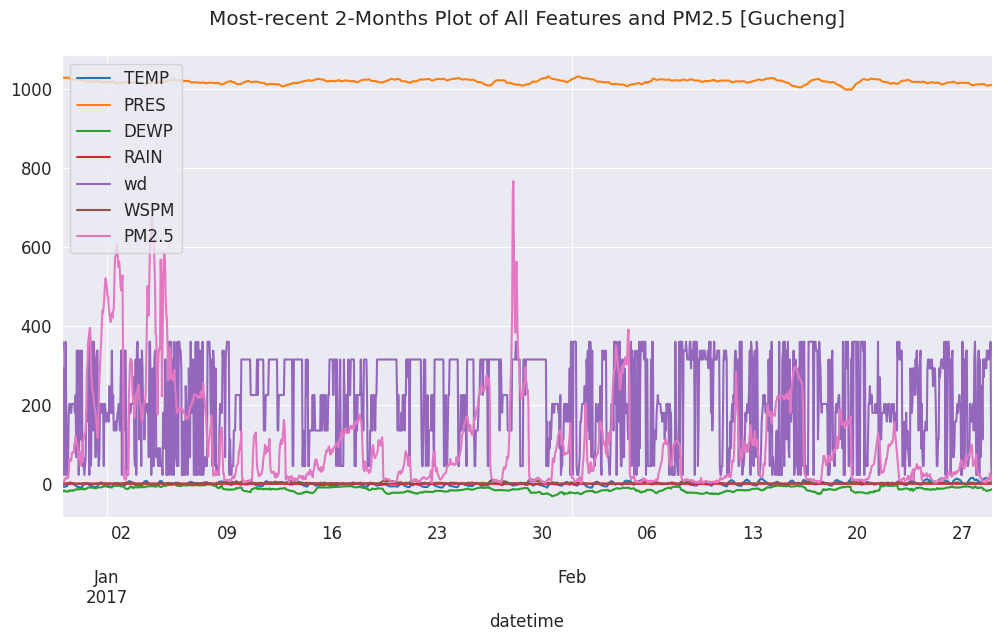

In [ ]:
for col in pm25_exog_data.columns:
    pm25_exog_data.iloc[-24*31*2:][col].plot(label=col)
plt.title('Most-recent 2-Months Plot of All Features and PM2.5 [Gucheng]\n')
plt.legend(loc='upper left')

#### Data Segmentation (Train-test split)

In [58]:
# last one month for testing (24 * 31 hours )
Xtrain_exo_pm25, ytrain_exo_pm25, Xtest_exo_pm25, ytest_exo_pm25 = split_train_test_series_multivariate_series(
    df=pm25_exog_data, test_size=steps)

print(f'Train set Dates:\t {ytrain_exo_pm25.index.min()}  --- {ytrain_exo_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_exo_pm25.index.min()}  --- {ytest_exo_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-21 23:00:00
Test set Dates:		 2017-02-22 00:00:00  --- 2017-02-28 23:00:00


In [59]:
Xtrain_exo_pm25.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM
datetime,,,,,,
2013-03-01 00:00:00,0.1,1021.1,-18.6,0.0,315.0,4.4
2013-03-01 01:00:00,-0.3,1021.5,-19.0,0.0,315.0,4.0
2013-03-01 02:00:00,-0.7,1021.5,-19.8,0.0,292.5,4.6


In [ ]:
ytrain_exo_pm25.head(3)

datetime
2013-03-01 00:00:00    6.0
2013-03-01 01:00:00    6.0
2013-03-01 02:00:00    5.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
Xtest_exo_pm25.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM
datetime,,,,,,
2017-02-22 00:00:00,-2.9,1017.1,-4.9,0.0,180.0,2.3
2017-02-22 01:00:00,-3.0,1016.6,-5.0,0.0,202.5,3.2
2017-02-22 02:00:00,-2.9,1016.0,-5.1,0.0,202.5,2.2


In [ ]:
ytest_exo_pm25.head(3)

datetime
2017-02-22 00:00:00     76.0
2017-02-22 01:00:00     91.0
2017-02-22 02:00:00    100.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Xtrain shape: {Xtrain_exo_pm25.shape}')
print(f'Xtest shape: {Xtest_exo_pm25.shape}')

Xtrain shape: (34896, 6)
Xtest shape: (168, 6)


Text(0.5, 1.0, 'PM2.5 [Gucheng]')

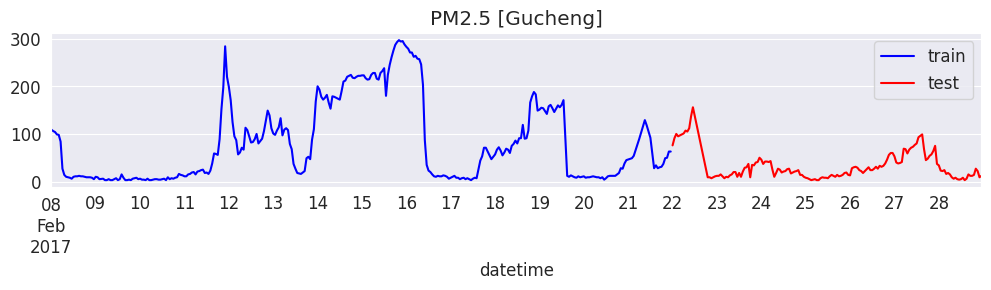

In [ ]:
plt.figure(figsize=(12,2))
ytrain_exo_pm25[-24*14:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 [Gucheng]')

#### Decision Tree

In [60]:
# Training
dt_forecaster_pm25_exo = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(
        criterion='squared_error',
        min_samples_split=2,
        random_state=60
        ),
    lags = lags)

dt_forecaster_pm25_exo.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
dt_forecaster_pm25_exo

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 60, 'splitter': 'best'} 
Creation date: 2023-05-15 23:01:54 
Last fit date: 2023-05-15 23:01:56 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: N

In [61]:
# Predictions
preds_pm25_dt_nt_exo = dt_forecaster_pm25_exo.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_dt_nt_exo.head()

2017-02-22 00:00:00    54.0
2017-02-22 01:00:00    43.0
2017-02-22 02:00:00    41.0
2017-02-22 03:00:00    37.0
2017-02-22 04:00:00    42.0
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, '7-Days Decision Tree Forecast of PM2.5 + All Exogenous Meteorological Predictor Variables \nusing 24-lags [Gucheng]\n')

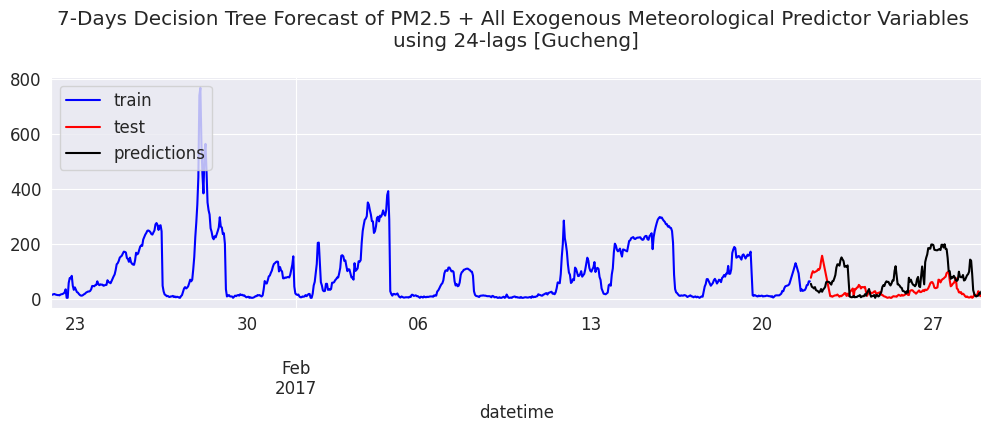

In [62]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*31:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_dt_nt_exo.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('7-Days Decision Tree Forecast of PM2.5 + All Exogenous Meteorological Predictor Variables \nusing 24-lags [Gucheng]\n')

In [63]:
# Evaluations
results_pm25_dt_notune_exo = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_dt_nt_exo, 
    label='dt_pm25_no_tune_exo')

results_pm25_dt_notune_exo

,dt_pm25_no_tune_exo
MAE,56.391
MSE,4966.085
RMSE,70.470
R-Squared,-4.008
MAPE,3.681


#### SVM (Regressor)

In [64]:
# Training
svm_forecaster_pm25_nt_exo = ForecasterAutoreg(
                regressor = LinearSVR(
                    epsilon=0.0, tol=0.0001, 
                    C=1.0, fit_intercept=True, 
                    random_state=60),
                lags = lags
             )

svm_forecaster_pm25_nt_exo.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
svm_forecaster_pm25_nt_exo

ForecasterAutoreg 
Regressor: LinearSVR(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': 60, 'tol': 0.0001, 'verbose': 0} 
Creation date: 2023-05-15 23:02:14 
Last fit date: 2023-05-15 23:02:32 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [65]:
# Predictions
preds_pm25_svm_nt_exo = svm_forecaster_pm25_nt_exo.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_svm_nt_exo.head()

2017-02-22 00:00:00     74.333097
2017-02-22 01:00:00     86.328624
2017-02-22 02:00:00     98.076156
2017-02-22 03:00:00    109.615570
2017-02-22 04:00:00    121.773035
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, '7-Days SVM Forecast of PM2.5 + All Exogenous Meteorological Predictor Variables \nusing 24-lags [Gucheng]\n')

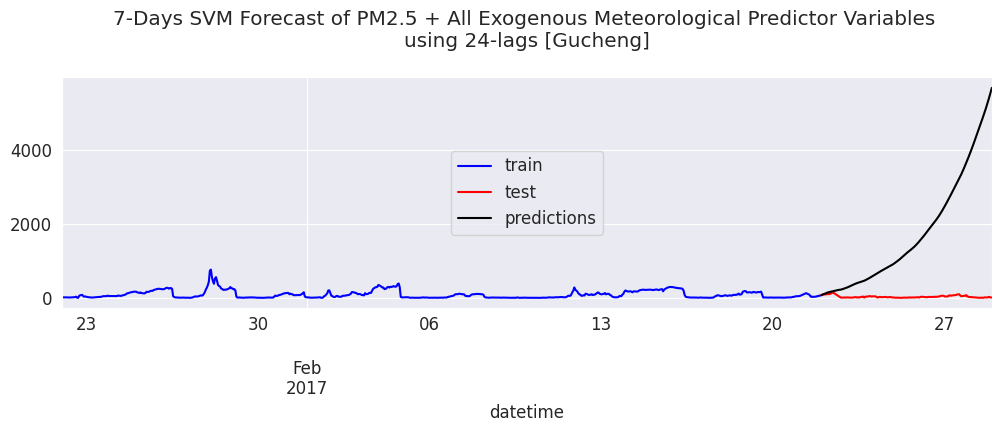

In [66]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*31:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_svm_nt_exo.plot(color='black', label='predictions')
plt.legend(loc='center')
plt.title('7-Days SVM Forecast of PM2.5 + All Exogenous Meteorological Predictor Variables \nusing 24-lags [Gucheng]\n')

In [67]:
# Evaluations
results_pm25_svm_notune_exo = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_svm_nt_exo, 
    label='svm_pm25_no_tune_exo')

results_pm25_svm_notune_exo

,svm_pm25_no_tune_exo
MAE,1711.619
MSE,5314232.832
RMSE,2305.262
R-Squared,-5357.749
MAPE,122.409


#### Radom Forest (Regressor)


In [68]:
# Training
rf_forecaster_pm25_nt_exo = ForecasterAutoreg(
                regressor =RandomForestRegressor(
                    n_estimators=150, criterion='squared_error', 
                    bootstrap=True, random_state=60),
                lags = lags
             )

rf_forecaster_pm25_nt_exo.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
rf_forecaster_pm25_nt_exo

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=150, random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 60, 'verbose': 0, 'warm_start': False} 
Creation da

In [69]:
# Predictions
preds_pm25_rf_nt_exo = rf_forecaster_pm25_nt_exo.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_rf_nt_exo.head()

2017-02-22 00:00:00    66.384762
2017-02-22 01:00:00    71.493333
2017-02-22 02:00:00    75.566667
2017-02-22 03:00:00    81.755143
2017-02-22 04:00:00    84.090000
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, '7-Days Random Forest Forecast of PM2.5 + All Exogenous Meteorological \nPredictor Variables using 24-lags [Gucheng]\n')

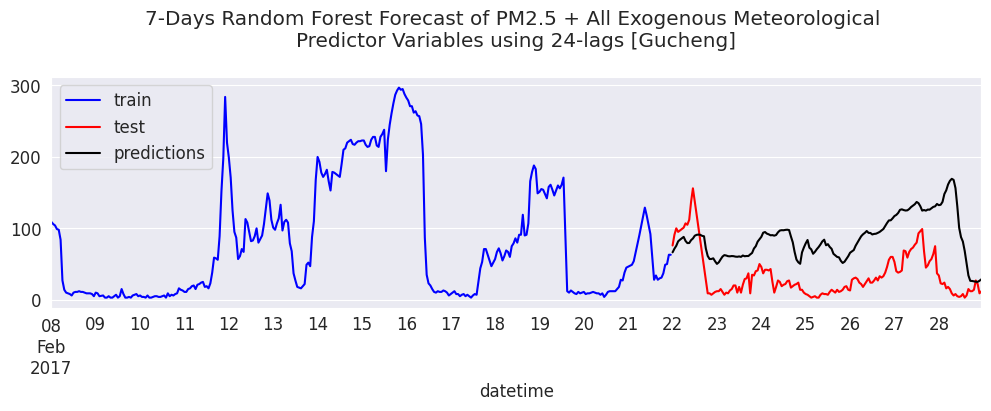

In [71]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*14:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_rf_nt_exo.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('7-Days Random Forest Forecast of PM2.5 + All Exogenous Meteorological \nPredictor Variables using 24-lags [Gucheng]\n')

In [72]:
# Evaluations
results_pm25_rf_notune_exo = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_rf_nt_exo, 
    label='rf_pm25_no_tune_exo')

results_pm25_rf_notune_exo

,rf_pm25_no_tune_exo
MAE,56.855
MSE,4054.420
RMSE,63.674
R-Squared,-3.088
MAPE,4.120


#### Combined Results

In [73]:
results_7_day_forecast_nt_exo = pd.concat([
    results_pm25_dt_notune_exo, 
    results_pm25_rf_notune_exo,
    results_pm25_svm_notune_exo
    ], axis='columns')
results_7_day_forecast_nt_exo

,dt_pm25_no_tune_exo,rf_pm25_no_tune_exo,svm_pm25_no_tune_exo
MAE,56.391,56.855,1711.619
MSE,4966.085,4054.420,5314232.832
RMSE,70.470,63.674,2305.262
R-Squared,-4.008,-3.088,-5357.749
MAPE,3.681,4.120,122.409


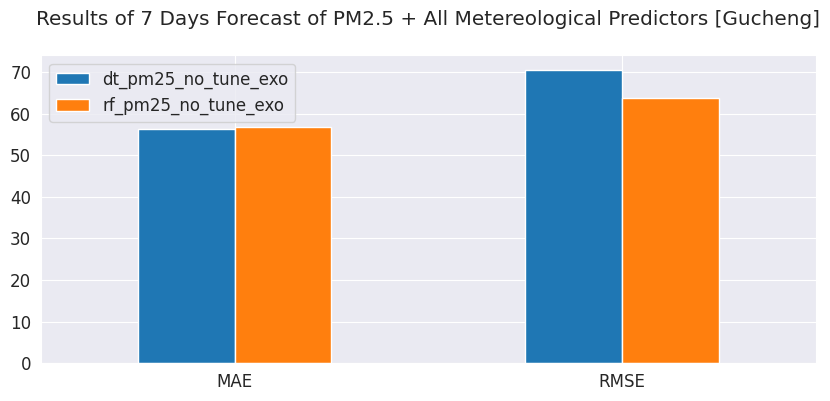

In [74]:
results_7_day_forecast_nt_exo.T[['MAE', 'RMSE']].sort_values(by='MAE').T.drop(
    columns=['svm_pm25_no_tune_exo']).plot.bar(
    title='Results of 7 Days Forecast of PM2.5 + All Metereological Predictors [Gucheng]\n',
    rot=0, figsize=(10,4))
plt.legend(loc='upper left')

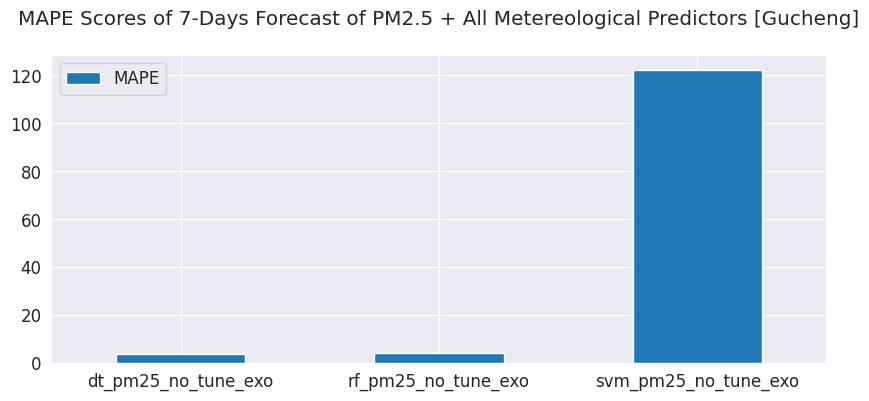

In [75]:
results_7_day_forecast_nt_exo.T['MAPE'].sort_values().T.plot.bar(
    title='MAPE Scores of 7-Days Forecast of PM2.5 + All Metereological Predictors [Gucheng]\n',
    rot=0, figsize=(10,4))
plt.legend(loc='upper left')

In [ ]:
# Saving a copy of results
results_7_day_forecast_nt_exo.to_csv(f'{RESULTS_PATH}/results_7_day_forecast_notune_all_exo_24lag_Gucheng.csv')

# MODEL OPTIMIZATION

1. Backtesting for time-series cross validation (walk-forward validation)
2. Forecast with Parameter Tunning using Grid Search

  **NOTE:**

  _We adopted a Backtesting with refit strategy, so that the model is refit (re-trained) each time to update the model to capture new series data, ensuring all data available for training are used._

---
- **Backtesting** refers to testing a predictive model on historical data by moving backward in time, step-by-step, in as many stages as is necessary. Therefore, it is a special type of cross-validation applied to previous period(s).

  **Backtesting with refit and increasing training size (fixed origin)**

  - The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

---

## 1. Backtesting Validation (Walk-forward Cross Validation)

### Seven Days (1 week = 168 hours) Forecast (trained with Exogenous Meterological Predictor Variables included) + Feature Selection
- Trained with exogenous meterology data
- 24 hours lag (use past 24 hrs data)
- One week (168 hrs) forecast
- Feature Selection (Selection based on Pearson correlation with PM2.5)
- Backtesting with refit (cross validation)

In [76]:
STEPS = 24 * 7
LAGS = 24

# setting 5 days data for backtesting
# to take the 'steps' forward 5 times from historical data
N_BACKTESTING = STEPS * 5 

#### Preparing data and Feature Selection

**Selected Features are {'WSPM', 'wd', 'TEMP'}**

In [77]:
pm25_exog_data = pd.concat([features_X[['WSPM', 'wd', 'TEMP']], y_pm25], axis='columns')
pm25_exog_data.head(3)

,WSPM,wd,TEMP,PM2.5
datetime,,,,
2013-03-01 00:00:00,4.4,315.0,0.1,6.0
2013-03-01 01:00:00,4.0,315.0,-0.3,6.0
2013-03-01 02:00:00,4.6,292.5,-0.7,5.0


#### Data Segmentation

In [78]:
# last one month for testing (24 * 31 hours )
Xtrain_exo_pm25, ytrain_exo_pm25, Xtest_exo_pm25, ytest_exo_pm25 = split_train_test_series_multivariate_series(
    df=pm25_exog_data, test_size=STEPS)

print(f'Train set Dates:\t {ytrain_exo_pm25.index.min()}  --- {ytrain_exo_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_exo_pm25.index.min()}  --- {ytest_exo_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-21 23:00:00
Test set Dates:		 2017-02-22 00:00:00  --- 2017-02-28 23:00:00


In [ ]:
print(f'Xtrain shape: {Xtrain_exo_pm25.shape}')
print(f'Xtest shape: {Xtest_exo_pm25.shape}')

Xtrain shape: (34896, 3)
Xtest shape: (168, 3)


#### Decision Tree on PM2.5 (with Backtesting)

In [79]:
eval_metrics = ['mean_absolute_error', 'mean_squared_error', 
                'mean_absolute_percentage_error']

dt_backtest_forecaster = ForecasterAutoreg(
        regressor = DecisionTreeRegressor(random_state=60),
        lags      = LAGS
      )

metrics, backtest_predictions = backtesting_forecaster(
        forecaster         = dt_backtest_forecaster,
        y                  = ytrain_exo_pm25,
        initial_train_size = len(ytrain_exo_pm25) - N_BACKTESTING,
        exog               = Xtrain_exo_pm25,
        interval           = [1, 99],
        fixed_train_size   = False,
        steps              = STEPS,
        metric             = eval_metrics,
        refit              = True,
        verbose            = True
    )

metrics.insert(2, np.sqrt(metrics[1]))
print(f'{"-" * 120}\nBacktest Errors (MAE, MSE, RMSE, MAPE): {metrics}\n{"-" * 120}\n')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 34056
Number of observations used for backtesting: 840
    Number of folds: 5
    Number of steps per fold: 168

Data partition in fold: 0
    Training:   2013-03-01 00:00:00 -- 2017-01-17 23:00:00  (n=34056)
    Validation: 2017-01-18 00:00:00 -- 2017-01-24 23:00:00  (n=168)
Data partition in fold: 1
    Training:   2013-03-01 00:00:00 -- 2017-01-24 23:00:00  (n=34224)
    Validation: 2017-01-25 00:00:00 -- 2017-01-31 23:00:00  (n=168)
Data partition in fold: 2
    Training:   2013-03-01 00:00:00 -- 2017-01-31 23:00:00  (n=34392)
    Validation: 2017-02-01 00:00:00 -- 2017-02-07 23:00:00  (n=168)
Data partition in fold: 3
    Training:   2013-03-01 00:00:00 -- 2017-02-07 23:00:00  (n=34560)
    Validation: 2017-02-08 00:00:00 -- 2017-02-14 23:00:00  (n=168)
Data partition in fold: 4
    Training:   2013-03-01 00:00:00 -- 2017-02-14 23:00:00  (n=34728)
    Validation:

In [80]:
backtest_predictions.head()

,pred,lower_bound,upper_bound
2017-01-18 00:00:00,156.0,156.0,156.0
2017-01-18 01:00:00,167.0,167.0,167.0
2017-01-18 02:00:00,176.0,176.0,176.0
2017-01-18 03:00:00,164.0,164.0,164.0
2017-01-18 04:00:00,127.0,127.0,127.0


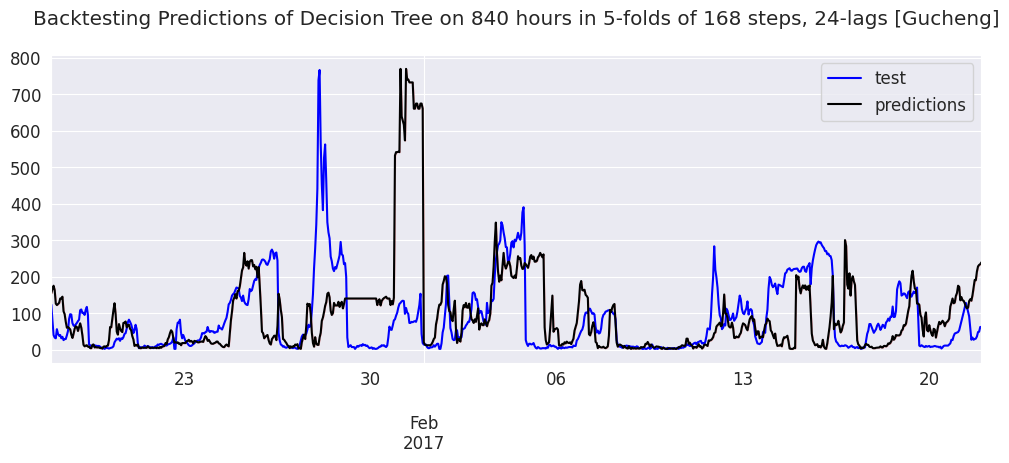

In [81]:
fig, ax = plt.subplots(figsize=(12, 4))
ytrain_exo_pm25.loc[backtest_predictions.index].plot(ax=ax, label='test', color='blue')
backtest_predictions['pred'].plot(ax=ax, label='predictions', color='black')
ax.fill_between(
    backtest_predictions.index,
    backtest_predictions['lower_bound'],
    backtest_predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.set_title('Backtesting Predictions of Decision Tree on 840 hours in 5-folds of 168 steps, 24-lags [Gucheng]\n')
ax.legend()

In [82]:
dt_backtest = evaluate_model_performance(
    ytrain_exo_pm25.loc[backtest_predictions.index], 
    backtest_predictions.pred, 
    label='dt_backtest')

dt_backtest

,dt_backtest
MAE,86.604
MSE,21363.421
RMSE,146.162
R-Squared,-1.148
MAPE,3.152


#### Random Forest Regressor (with Backtesting)

In [93]:
eval_metrics = ['mean_absolute_error', 'mean_squared_error', 
                'mean_absolute_percentage_error']

rf_backtest_forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(
                    n_estimators=150, criterion='squared_error', 
                    bootstrap=True, random_state=60),
        lags      = LAGS
      )

metrics, backtest_predictions = backtesting_forecaster(
        forecaster         = rf_backtest_forecaster,
        y                  = ytrain_exo_pm25,
        initial_train_size = len(ytrain_exo_pm25) - N_BACKTESTING,
        exog               = Xtrain_exo_pm25,
        # interval           = [1, 99],
        fixed_train_size   = False,
        steps              = STEPS,
        metric             = eval_metrics,
        refit              = True,
        verbose            = True
    )

metrics.insert(2, np.sqrt(metrics[1]))
print(f'{"-" * 120}\nBacktest Errors (MAE, MSE, RMSE, MAPE): {metrics}\n{"-" * 120}\n')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 34056
Number of observations used for backtesting: 840
    Number of folds: 5
    Number of steps per fold: 168

Data partition in fold: 0
    Training:   2013-03-01 00:00:00 -- 2017-01-17 23:00:00  (n=34056)
    Validation: 2017-01-18 00:00:00 -- 2017-01-24 23:00:00  (n=168)
Data partition in fold: 1
    Training:   2013-03-01 00:00:00 -- 2017-01-24 23:00:00  (n=34224)
    Validation: 2017-01-25 00:00:00 -- 2017-01-31 23:00:00  (n=168)
Data partition in fold: 2
    Training:   2013-03-01 00:00:00 -- 2017-01-31 23:00:00  (n=34392)
    Validation: 2017-02-01 00:00:00 -- 2017-02-07 23:00:00  (n=168)
Data partition in fold: 3
    Training:   2013-03-01 00:00:00 -- 2017-02-07 23:00:00  (n=34560)
    Validation: 2017-02-08 00:00:00 -- 2017-02-14 23:00:00  (n=168)
Data partition in fold: 4
    Training:   2013-03-01 00:00:00 -- 2017-02-14 23:00:00  (n=34728)
    Validation:

In [94]:
backtest_predictions.head()

,pred
2017-01-18 00:00:00,158.586667
2017-01-18 01:00:00,157.064762
2017-01-18 02:00:00,149.413333
2017-01-18 03:00:00,142.466374
2017-01-18 04:00:00,137.430586


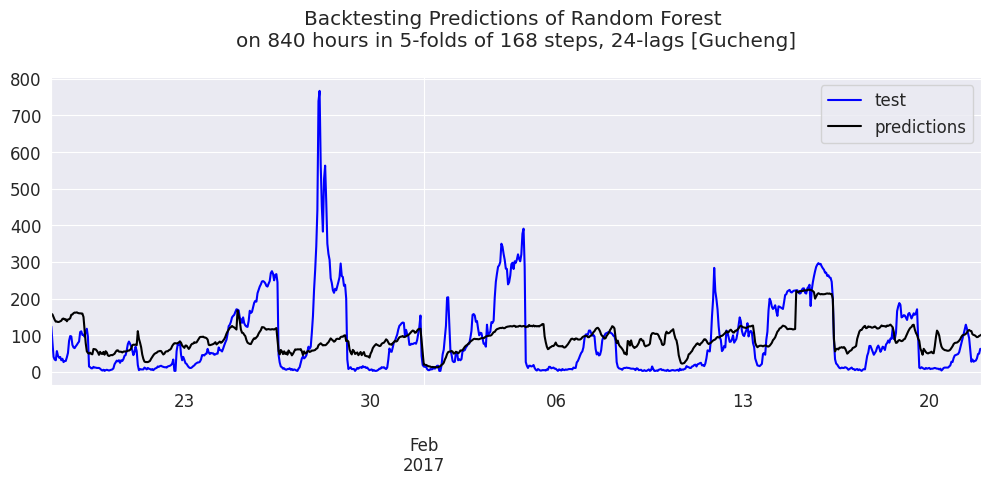

In [95]:
fig, ax = plt.subplots(figsize=(12, 4))
ytrain_exo_pm25.loc[backtest_predictions.index].plot(ax=ax, label='test', color='blue')
backtest_predictions['pred'].plot(ax=ax, label='predictions', color='black')
# ax.fill_between(
#     backtest_predictions.index,
#     backtest_predictions['lower_bound'],
#     backtest_predictions['upper_bound'],
#     color = 'red',
#     alpha = 0.2
# )
ax.set_title('Backtesting Predictions of Random Forest \non 840 hours in 5-folds of 168 steps, 24-lags [Gucheng]\n')
ax.legend()

In [96]:
rf_backtest = evaluate_model_performance(
    ytrain_exo_pm25.loc[backtest_predictions.index], 
    backtest_predictions.pred, 
    label='rf_backtest')

rf_backtest

,rf_backtest
MAE,61.603
MSE,7773.673
RMSE,88.168
R-Squared,0.218
MAPE,3.591


#### Support Vector Machine (Regressor) (with Backtesting)

In [97]:
eval_metrics = ['mean_absolute_error', 'mean_squared_error', 
                'mean_absolute_percentage_error']

svm_backtest_forecaster = ForecasterAutoreg(
        regressor = LinearSVR(
                    epsilon=0.0, tol=0.0001, 
                    C=1.0, fit_intercept=True, 
                    random_state=60),
        lags      = LAGS
      )

metrics, backtest_predictions = backtesting_forecaster(
        forecaster         = svm_backtest_forecaster,
        y                  = ytrain_exo_pm25,
        initial_train_size = len(ytrain_exo_pm25) - N_BACKTESTING,
        exog               = Xtrain_exo_pm25,
        # interval           = [1, 99],
        fixed_train_size   = False,
        steps              = STEPS,
        metric             = eval_metrics,
        refit              = True,
        verbose            = True
    )

metrics.insert(2, np.sqrt(metrics[1]))
print(f'{"-" * 120}\nBacktest Errors (MAE, MSE, RMSE, MAPE): {metrics}\n{"-" * 120}\n')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 34056
Number of observations used for backtesting: 840
    Number of folds: 5
    Number of steps per fold: 168

Data partition in fold: 0
    Training:   2013-03-01 00:00:00 -- 2017-01-17 23:00:00  (n=34056)
    Validation: 2017-01-18 00:00:00 -- 2017-01-24 23:00:00  (n=168)
Data partition in fold: 1
    Training:   2013-03-01 00:00:00 -- 2017-01-24 23:00:00  (n=34224)
    Validation: 2017-01-25 00:00:00 -- 2017-01-31 23:00:00  (n=168)
Data partition in fold: 2
    Training:   2013-03-01 00:00:00 -- 2017-01-31 23:00:00  (n=34392)
    Validation: 2017-02-01 00:00:00 -- 2017-02-07 23:00:00  (n=168)
Data partition in fold: 3
    Training:   2013-03-01 00:00:00 -- 2017-02-07 23:00:00  (n=34560)
    Validation: 2017-02-08 00:00:00 -- 2017-02-14 23:00:00  (n=168)
Data partition in fold: 4
    Training:   2013-03-01 00:00:00 -- 2017-02-14 23:00:00  (n=34728)
    Validation:

In [98]:
backtest_predictions.head()

,pred
2017-01-18 00:00:00,199.271536
2017-01-18 01:00:00,241.500189
2017-01-18 02:00:00,284.826694
2017-01-18 03:00:00,329.974193
2017-01-18 04:00:00,380.966015


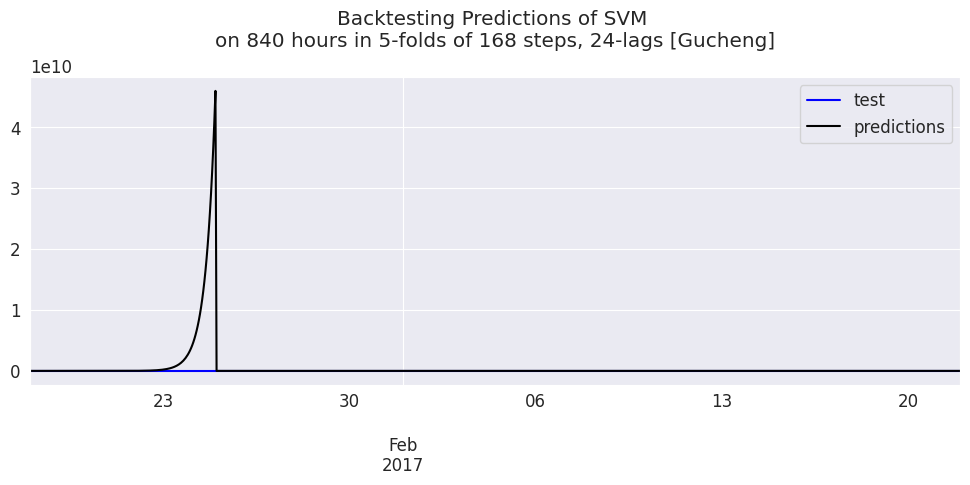

In [99]:
fig, ax = plt.subplots(figsize=(12, 4))
ytrain_exo_pm25.loc[backtest_predictions.index].plot(ax=ax, label='test', color='blue')
backtest_predictions['pred'].plot(ax=ax, label='predictions', color='black')
# ax.fill_between(
#     backtest_predictions.index,
#     backtest_predictions['lower_bound'],
#     backtest_predictions['upper_bound'],
#     color = 'red',
#     alpha = 0.2
# )
ax.set_title('Backtesting Predictions of SVM \non 840 hours in 5-folds of 168 steps, 24-lags [Gucheng]\n')
ax.legend()

In [100]:
svm_backtest = evaluate_model_performance(
    ytrain_exo_pm25.loc[backtest_predictions.index], 
    backtest_predictions.pred, 
    label='svm_backtest')

svm_backtest

,svm_backtest
MAE,5.069990e+08
MSE,1.230841e+19
RMSE,3.508335e+09
R-Squared,-1.237842e+15
MAPE,5.680694e+06


#### Combined Backtesting Performance Results

In [101]:
backtest_results_exo_sel_24lags = pd.concat([dt_backtest, rf_backtest, svm_backtest], axis='columns')
backtest_results_exo_sel_24lags

,dt_backtest,rf_backtest,svm_backtest
MAE,86.604,61.603,5.069990e+08
MSE,21363.421,7773.673,1.230841e+19
RMSE,146.162,88.168,3.508335e+09
R-Squared,-1.148,0.218,-1.237842e+15
MAPE,3.152,3.591,5.680694e+06


<Axes: title={'center': 'Results of Backtesting with All Algorithms (MAE & RMSE) [Gucheng]\n'}>

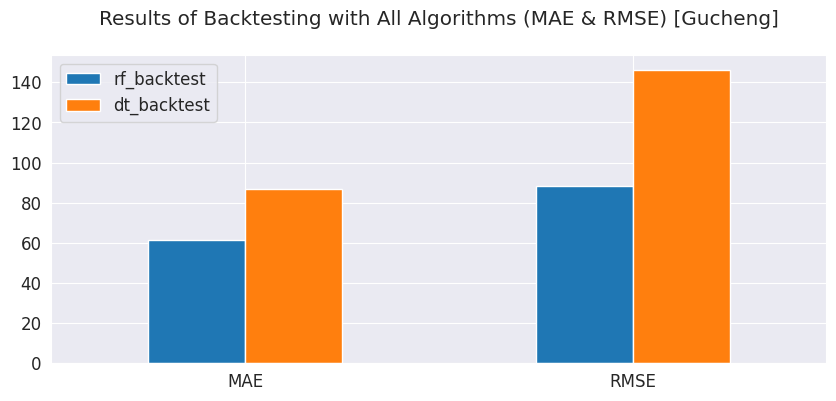

In [102]:
backtest_results_exo_sel_24lags.T[['MAE', 'RMSE']].sort_values(by='MAE').T.drop(columns=['svm_backtest']).plot.bar(
    title='Results of Backtesting with All Algorithms (MAE & RMSE) [Gucheng]\n', rot=0,
    figsize=(10,4)
)

<Axes: title={'center': 'Mean Absolute Percentage Error (MAPE) of Backtesting with All Algorithms [Gucheng]\n'}>

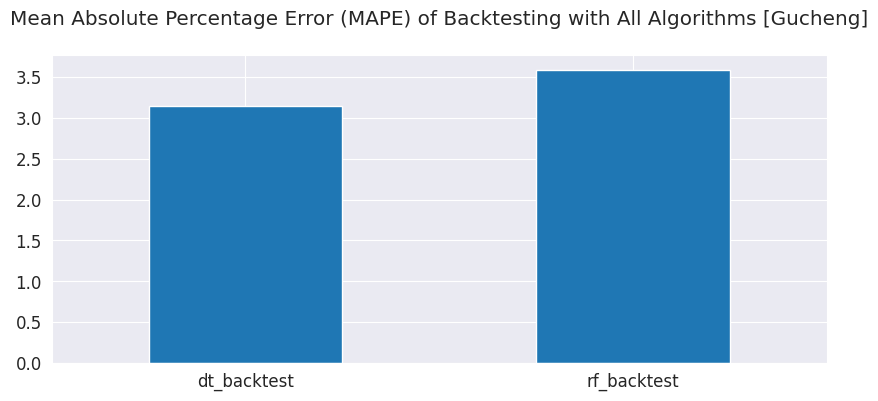

In [106]:
backtest_results_exo_sel_24lags.drop(columns=['svm_backtest']).T['MAPE'].sort_values().T.plot.bar(
    title='Mean Absolute Percentage Error (MAPE) of Backtesting with All Algorithms [Gucheng]\n', rot=0,
    figsize=(10,4)
)

In [ ]:
backtest_results_exo_sel_24lags.iloc[3].sort_values()

svm_backtest   -1.237842e+15
dt_backtest    -1.148000e+00
rf_backtest     2.180000e-01
Name: R-Squared, dtype: float64

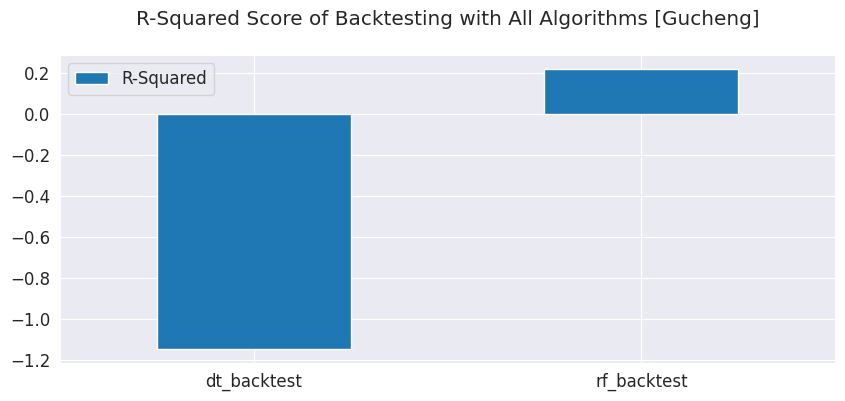

In [107]:
backtest_results_exo_sel_24lags.iloc[3,:].sort_values()[1:].plot.bar(
    title='R-Squared Score of Backtesting with All Algorithms [Gucheng]\n', rot=0,
    figsize=(10,4)
)
plt.legend()

In [108]:
backtest_results_exo_sel_24lags.to_csv(f'{RESULTS_PATH}/backtest_results_exo_sel_24lags_Gucheng.csv')

---
NOTE: 

GRID SEARCH has not been run at all

---

## 2. Grid Search Parameter Tunning

### Seven Days (1 week = 168 hours) Forecast (trained with Exogenous Meterological Predictor Variables included) + All-Features
- Trained with exogenous meterology data
- 24 hours lag (use past 24 hrs data)
- One week (168 hrs) forecast
- Feature Selection (Selection based on Pearson correlation with PM2.5)
- Grid Search Parameter Tunning

In [ ]:
STEPS = 24 * 7

#### Preparing data and Feature Selection

**Selected Features are {'WSPM', 'wd', 'TEMP'}**

In [ ]:
pm25_exog_data = pd.concat([features_X[['WSPM', 'wd', 'TEMP']], y_pm25], axis='columns')
pm25_exog_data.head(3)

,WSPM,wd,TEMP,PM2.5
datetime,,,,
2013-03-01 00:00:00,5.7,337.5,-0.5,5.0
2013-03-01 01:00:00,3.9,315.0,-0.7,8.0
2013-03-01 02:00:00,5.3,337.5,-1.2,3.0


#### Data Segmentation

In [ ]:
# last one month for testing (24 * 31 hours )
Xtrain_exo_pm25, ytrain_exo_pm25, Xtest_exo_pm25, ytest_exo_pm25 = split_train_test_series_multivariate_series(
    df=pm25_exog_data, test_size=STEPS)

print(f'Train set Dates:\t {ytrain_exo_pm25.index.min()}  --- {ytrain_exo_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_exo_pm25.index.min()}  --- {ytest_exo_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-21 23:00:00
Test set Dates:		 2017-02-22 00:00:00  --- 2017-02-28 23:00:00


In [ ]:
print(f'Xtrain shape: {Xtrain_exo_pm25.shape}')
print(f'Xtest shape: {Xtest_exo_pm25.shape}')

Xtrain shape: (34896, 3)
Xtest shape: (168, 3)


In [ ]:
# Lags used as predictors
LAGS_GRID = [24, 36, 48]

# DTree Regressor's hyperparameters
param_grid_dt = {
    "splitter":["best","random"],
    "max_depth" : [5, 10, 20],
    "max_leaf_nodes":[None, 10, 20] 
    }


# Rabdom Forest Regressor's hyperparameters
param_grid_rf = {
    "n_estimators": [100, 150],
    "max_depth": [10, 20]
    }


# SVM Regressor's hyperparameters
param_grid_svr = {
    'C': [1.0, 5.0, 10.0],
    'loss' : ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'epsilon': [0.0, 0.01, 0.1,]
    }


#### Decision Tree on PM2.5 (with Hyperparameter Tunning)

In [ ]:
dt_grid_forecaster = ForecasterAutoreg(
        regressor = DecisionTreeRegressor(random_state=60),
        lags      = 24 # This value is replaced in the grid search
      )


dt_results_grid = grid_search_forecaster(
        forecaster         = dt_grid_forecaster,
        y                  = ytrain_exo_pm25,
        param_grid         = param_grid_dt,
        lags_grid          = LAGS_GRID,
        steps              = STEPS,
        refit              = True,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(ytrain_exo_pm25)*0.5),
        exog               = Xtrain_exo_pm25,
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
      )


In [ ]:
# Grid Search results for Decision Tree
# ======================================
dt_results_grid

In [ ]:
best_params = {'max_depth': 20, 'max_leaf_nodes': None, 'splitter': 'best'}
best_lag = 24

# Training
dt_grid_forecaster_final = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(
        **best_params,
        random_state=60
        ),
    lags = best_lag)

dt_grid_forecaster_final.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
dt_grid_forecaster_final

In [ ]:
# Predictions
preds_pm25_dt_exo_sel_grid = dt_grid_forecaster_final.predict(steps=STEPS, exog=Xtest_exo_pm25)
preds_pm25_dt_exo_sel_grid.head()

In [ ]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*31:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_dt_exo_sel_grid.plot(color='orange', label='predictions')
plt.legend(loc='upper left')
plt.title('7-Days Decision Tree Grid_Search_Params Forecast of PM2.5 + Selected Exogenous \nMeteorological Predictor Variables using 24-lags [Gucheng]\n')

In [ ]:
# Evaluations
results_pm25_dt_notune_exo_sel_grid = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_dt_exo_sel_grid, 
    label='dt_pm25_grid_tune_exo')

results_pm25_dt_notune_exo_sel_grid

#### Random Forest (best Hyperparam Grid Search)

In [ ]:
rf_grid_forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=60),
        lags      = 24 # This value is replaced in the grid search
      )


rf_results_grid = grid_search_forecaster(
        forecaster         = rf_grid_forecaster,
        y                  = ytrain_exo_pm25,
        param_grid         = param_grid_rf,
        lags_grid          = [24, 36],
        steps              = STEPS,
        refit              = True,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(ytrain_exo_pm25)*0.5),
        exog               = Xtrain_exo_pm25,
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
      )

In [ ]:
# Grid Search results for Random Forest
# ======================================
rf_results_grid

#### Support Vector Machine Regressor (best Hyperparam Grid Search)

In [ ]:
svr_grid_forecaster = ForecasterAutoreg(
        regressor = LinearSVR(random_state=60),
        lags      = 24 # This value is replaced in the grid search
      )


svr_results_grid = grid_search_forecaster(
        forecaster         = svm_grid_forecaster,
        y                  = ytrain_exo_pm25,
        param_grid         = param_grid_svr,
        lags_grid          = LAGS_GRID,
        steps              = STEPS,
        refit              = True,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(ytrain_exo_pm25)*0.5),
        exog               = Xtrain_exo_pm25,
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
      )

In [ ]:
# Grid Search results for Support Vector Machine (Regressor)
# ==========================================================
svr_results_grid

---

---
# ACESSING THE POTENTIALS OF METEROLOGICAL VARIABLES IN PREDICTING within-Sample PM2.5 (using Machine Learning Approach)

---

---

## Prediction

### Data Preparation and Segmentation

In [109]:
TEST_SIZE = int((30 / 100) * len(y_pm25))

print(f'Test Size (30%): {TEST_SIZE}')

Test Size (30%): 10519


In [110]:
features_X.corrwith(y_pm25).sort_values()

WSPM   -0.251702
TEMP   -0.145860
wd     -0.025076
RAIN   -0.020184
PRES    0.022596
DEWP    0.097060
dtype: float64

In [111]:
# selecting only correlated features only
data = pd.concat([features_X[['WSPM','TEMP', 'DEWP']], y_pm25], axis='columns')
data.head(3)

,WSPM,TEMP,DEWP,PM2.5
datetime,,,,
2013-03-01 00:00:00,4.4,0.1,-18.6,6.0
2013-03-01 01:00:00,4.0,-0.3,-19.0,6.0
2013-03-01 02:00:00,4.6,-0.7,-19.8,5.0


In [112]:
# Train test split
X_train, y_train, X_test, y_test = split_train_test_series_multivariate_series(
    data, test_size=TEST_SIZE)

In [113]:
print(f'Shape of X: {data.iloc[:,:-1].shape}')
print(f'Shape of X-train: {X_train.shape}')
print(f'Shape of X-test: {X_test.shape}')

Shape of X: (35064, 3)
Shape of X-train: (24545, 3)
Shape of X-test: (10519, 3)


In [114]:
X_train.head(3)

,WSPM,TEMP,DEWP
datetime,,,
2013-03-01 00:00:00,4.4,0.1,-18.6
2013-03-01 01:00:00,4.0,-0.3,-19.0
2013-03-01 02:00:00,4.6,-0.7,-19.8


In [ ]:
y_train.head(3)

datetime
2013-03-01 00:00:00    6.0
2013-03-01 01:00:00    6.0
2013-03-01 02:00:00    5.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
X_test.head(3)

,WSPM,TEMP,DEWP
datetime,,,
2015-12-18 17:00:00,0.8,5.5,-11.2
2015-12-18 18:00:00,0.6,2.2,-9.1
2015-12-18 19:00:00,0.6,0.6,-8.4


In [ ]:
y_test.head(3)

datetime
2015-12-18 17:00:00    31.0
2015-12-18 18:00:00    40.0
2015-12-18 19:00:00    62.0
Freq: H, Name: PM2.5, dtype: float64

### Decision Tree

In [115]:
# initializing model
dt_pm25 = DecisionTreeRegressor(criterion='squared_error', min_samples_split=2, 
                                random_state=60)

# training the model
dt_pm25.fit(X_train, y_train)

# making prediction
dt_pred_pm25 = dt_pm25.predict(X_test)

In [116]:
# Evaluations
dt_results_pm25 = evaluate_model_performance(
    y_true=y_test, predictions=dt_pred_pm25, label='dt_pm25')

dt_results_pm25

,dt_pm25
MAE,68.920
MSE,10774.433
RMSE,103.800
R-Squared,-0.254
MAPE,1.866


### SVM Regressor

In [117]:
# initializing model
svr_pm25 = LinearSVR(epsilon=0.0, tol=0.0001, C=1.0, fit_intercept=True, random_state=60)

# training the model
svr_pm25.fit(X_train, y_train)

# making prediction
svr_pred_pm25 = svr_pm25.predict(X_test)

In [118]:
# Evaluations
svr_results_pm25 = evaluate_model_performance(
    y_true=y_test, predictions=svr_pred_pm25, label='svr_pm25')

svr_results_pm25

,svr_pm25
MAE,54.379
MSE,7811.399
RMSE,88.382
R-Squared,0.091
MAPE,1.386


### RF Regressor

In [119]:
# initializing model
rf_pm25 = RandomForestRegressor(
    n_estimators=150, criterion='squared_error', 
    bootstrap=True, random_state=60)

# training the model
rf_pm25.fit(X_train, y_train)

# making prediction
rf_pred_pm25 = rf_pm25.predict(X_test)

In [120]:
# Evaluations
rf_results_pm25 = evaluate_model_performance(
    y_true=y_test, predictions=rf_pred_pm25, label='rf_pm25')

rf_results_pm25

,rf_pm25
MAE,55.480
MSE,6773.845
RMSE,82.303
R-Squared,0.212
MAPE,1.584


### PM2.5 Models Performance Comparisons

In [121]:
results_pm25 = pd.concat([dt_results_pm25, rf_results_pm25, svr_results_pm25], axis='columns')

results_pm25

,dt_pm25,rf_pm25,svr_pm25
MAE,68.920,55.480,54.379
MSE,10774.433,6773.845,7811.399
RMSE,103.800,82.303,88.382
R-Squared,-0.254,0.212,0.091
MAPE,1.866,1.584,1.386


<Axes: title={'center': 'Machine Learning Approach for Meterological Variables Predictions of PM2.5 [Gucheng]\n'}>

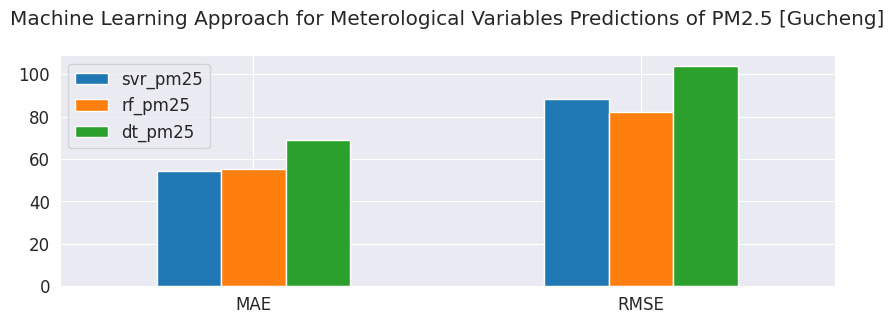

In [ ]:
results_pm25.iloc[[0, 2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Machine Learning Approach for Meterological Variables Predictions of PM2.5 [Gucheng]\n', 
    figsize=(10,3), rot=0)

<Axes: title={'center': 'Mean Absolute Error(MAE) of MET. Variables Predictions of PM2.5 [Gucheng]\n'}>

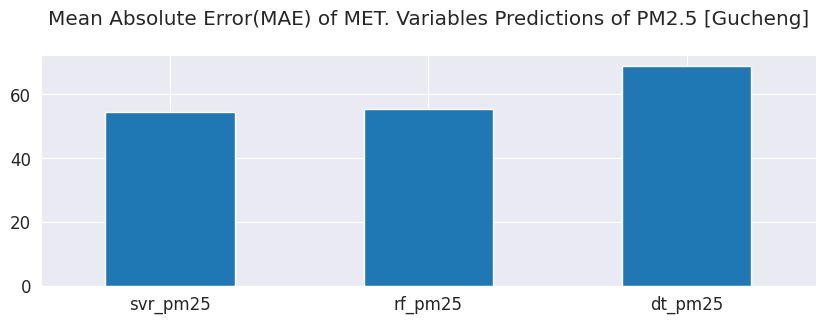

In [ ]:
results_pm25.iloc[0,:].T.sort_values().T.plot.bar(
    title='Mean Absolute Error(MAE) of MET. Variables Predictions of PM2.5 [Gucheng]\n', 
    figsize=(10,3), rot=0)

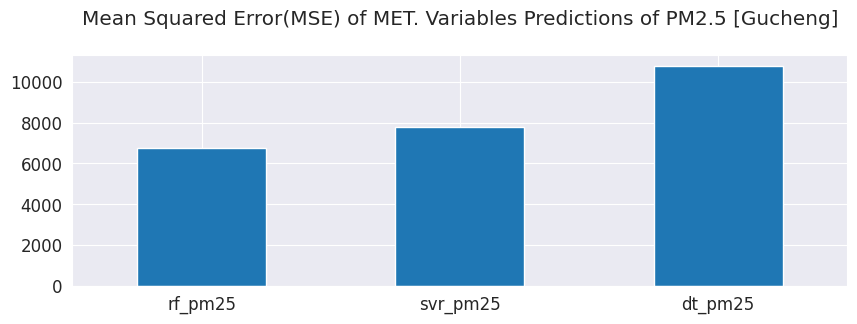

In [ ]:
results_pm25.iloc[1,:].T.sort_values().T.plot.bar(
    title='Mean Squared Error(MSE) of MET. Variables Predictions of PM2.5 [Gucheng]\n', 
    figsize=(10,3), rot=0)

<Axes: title={'center': 'Root Mean Squared Error(RMSE) of MET. Variables Predictions of PM2.5 [Gucheng]\n'}>

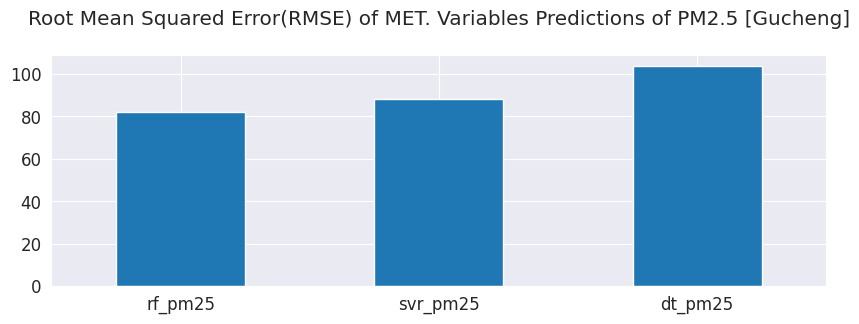

In [ ]:
results_pm25.iloc[2,:].T.sort_values().T.plot.bar(
    title='Root Mean Squared Error(RMSE) of MET. Variables Predictions of PM2.5 [Gucheng]\n', 
    figsize=(10,3), rot=0)

<Axes: title={'center': 'MAPE (Mean Absolute Percentage Error) of MET. Variables Predictions of PM2.5 [Gucheng]\n'}>

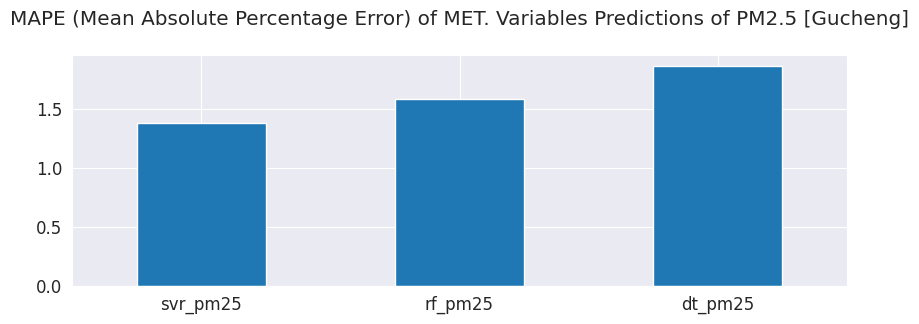

In [ ]:
results_pm25.iloc[4].T.sort_values().T.plot.bar(
    title='MAPE (Mean Absolute Percentage Error) of MET. Variables Predictions of PM2.5 [Gucheng]\n', 
    figsize=(10,3), rot=0)

<Axes: title={'center': 'R-Squred Score of MET. Variables Predictions of PM2.5 [Gucheng]\n'}>

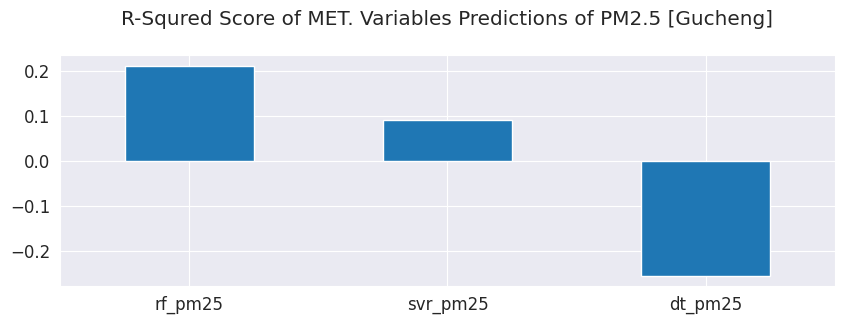

In [ ]:
results_pm25.iloc[3].T.sort_values(ascending=False).T.plot.bar(
    title='R-Squred Score of MET. Variables Predictions of PM2.5 [Gucheng]\n', 
    figsize=(10,3), rot=0)

In [ ]:
# Saving a copy of results
results_pm25.to_csv(f'{RESULTS_PATH}/results_Gucheng_ML_Approach_meterology_for_PM25_Gucheng.csv')